<h1> Amazon Apparel Recommendations </h1>



### [4.2] Data and Code:
https://drive.google.com/open?id=0BwNkduBnePt2VWhCYXhMV3p4dTg



### [4.3] Overview of the data

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')


Of these 19 features, we will be using only 6 features in this workshop.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

####  Basic stats for the feature: brand

In [3]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [4]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

####  Basic stats for the feature: color

In [5]:

print(data['color'].describe())


# we have 7380 unique colors
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. That's approx 35.4%.

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [6]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [7]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [8]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [9]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this workshop 
# as they are short and informative.


count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


## Stemming 

In [10]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


# We tried using stemming on our titles and it didnot work very well. 


argu
fish


# [8] Text based product similarity

In [11]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [12]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## [8.2] Bag of Words (BoW) on product titles.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus

# What is a sparse vector?

# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc



(16042, 12609)

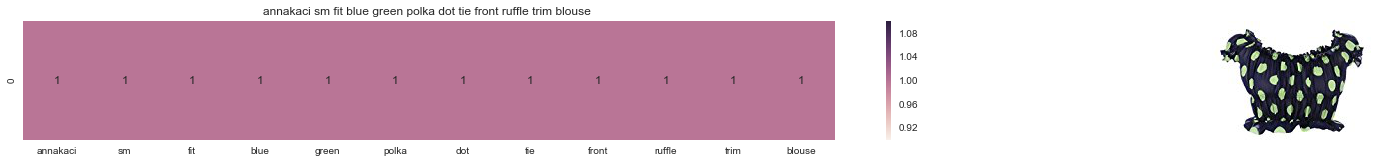

ASIN : B00KLHUIBS
Brand: Anna-Kaci
Title: annakaci sm fit blue green polka dot tie front ruffle trim blouse 
Euclidean similarity with the query image : 0.0


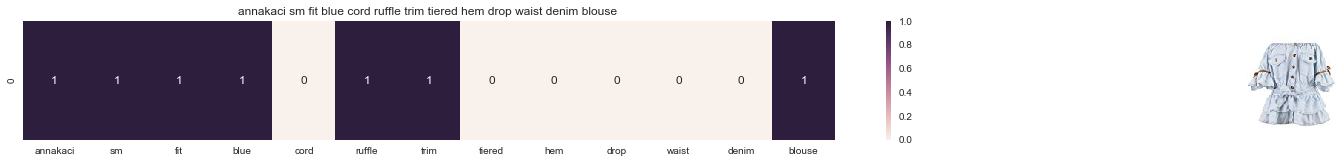

ASIN : B0759G15ZX
Brand: Anna-Kaci
Title: annakaci sm fit blue cord ruffle trim tiered hem drop waist denim blouse 
Euclidean similarity with the query image : 3.31662479036


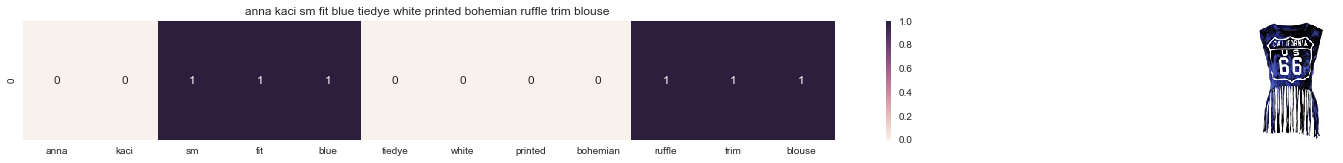

ASIN : B00YQ8S4K0
Brand: Anna-Kaci
Title: anna kaci sm fit blue tiedye white printed bohemian ruffle trim blouse 
Euclidean similarity with the query image : 3.46410161514


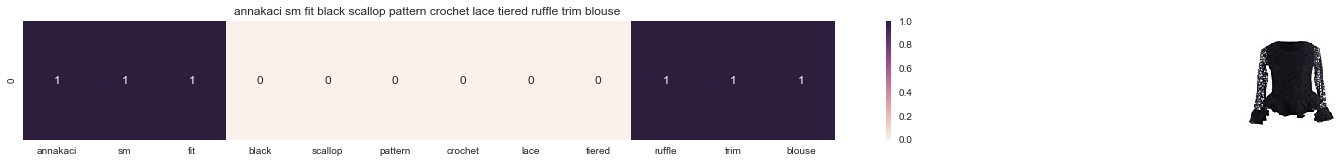

ASIN : B00O194W8W
Brand: Anna-Kaci
Title: annakaci sm fit black scallop pattern crochet lace tiered ruffle trim blouse 
Euclidean similarity with the query image : 3.46410161514


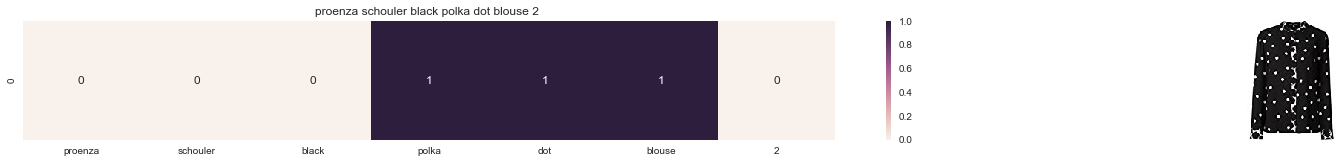

ASIN : B074TLHLMN
Brand: Proenza Schouler
Title: proenza schouler black polka dot blouse 2 
Euclidean similarity with the query image : 3.46410161514


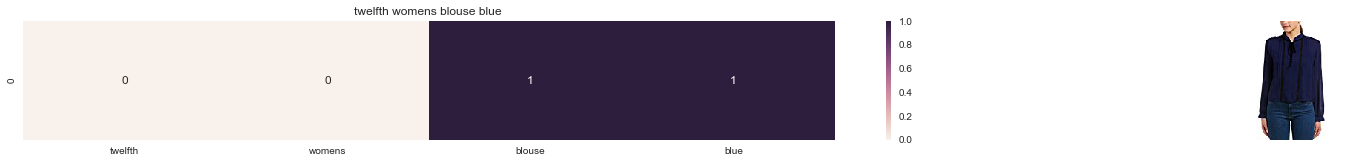

ASIN : B074F5BP5F
Brand: On Twelfth
Title: twelfth womens blouse blue 
Euclidean similarity with the query image : 3.46410161514


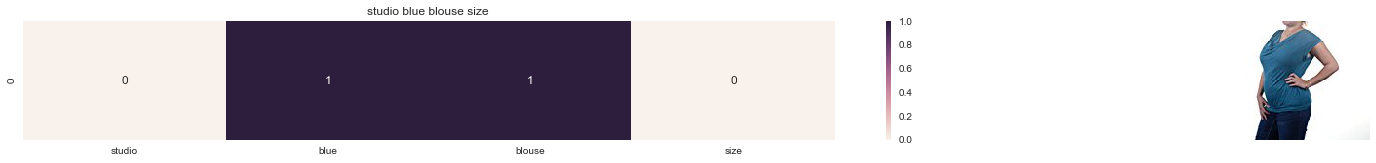

ASIN : B016P80OKQ
Brand: Studio M
Title: studio blue blouse size 
Euclidean similarity with the query image : 3.46410161514


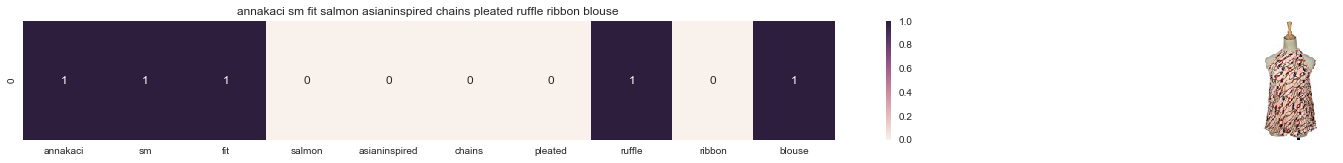

ASIN : B007KSG42S
Brand: Anna-Kaci
Title: annakaci sm fit salmon asianinspired chains pleated ruffle ribbon blouse 
Euclidean similarity with the query image : 3.46410161514


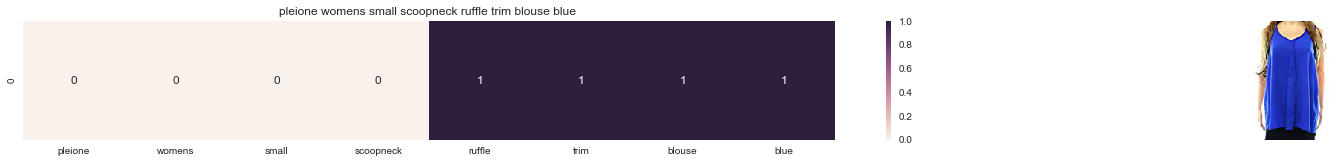

ASIN : B072VHTT1D
Brand: Pleione
Title: pleione womens small scoopneck ruffle trim blouse blue 
Euclidean similarity with the query image : 3.46410161514


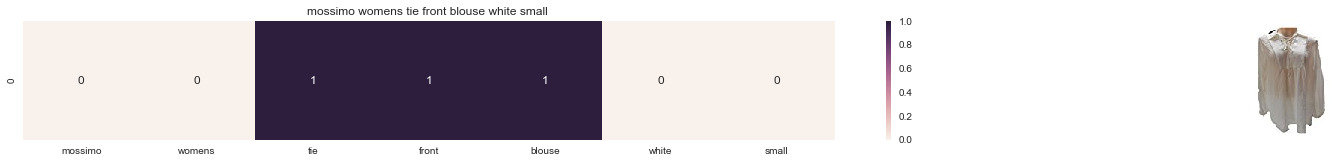

ASIN : B07111HHX6
Brand: Mossimo
Title: mossimo womens tie front blouse white small 
Euclidean similarity with the query image : 3.60555127546


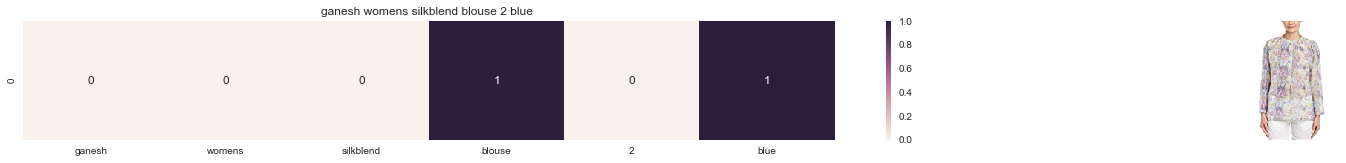

ASIN : B01N3SAT1F
Brand: Ganesh
Title: ganesh womens silkblend blouse 2 blue 
Euclidean similarity with the query image : 3.60555127546


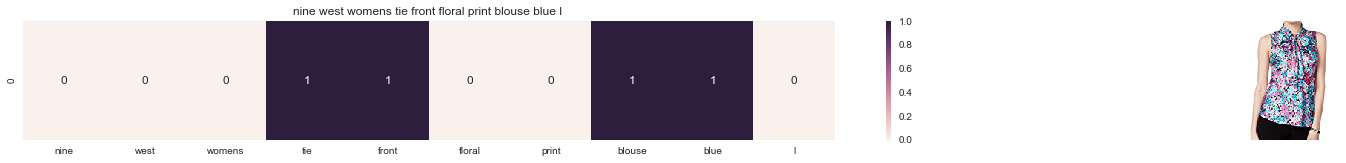

ASIN : B06WW5C6NJ
Brand: Nine West
Title: nine west womens tie front floral print blouse blue l 
Euclidean similarity with the query image : 3.60555127546


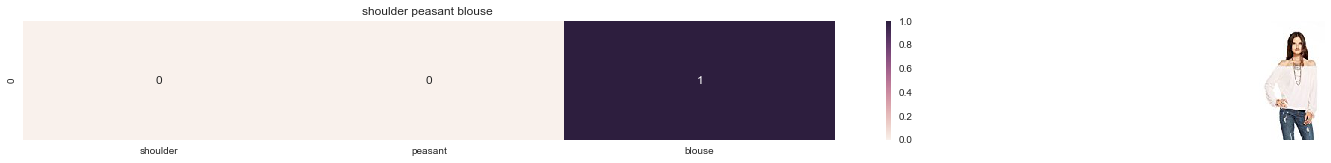

ASIN : B01E1QD5PK
Brand: CHASER
Title: shoulder peasant blouse 
Euclidean similarity with the query image : 3.60555127546


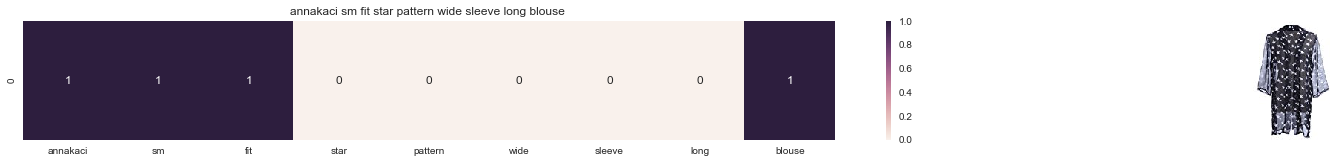

ASIN : B00G5RYY18
Brand: Anna-Kaci
Title: annakaci sm fit star pattern wide sleeve long blouse 
Euclidean similarity with the query image : 3.60555127546


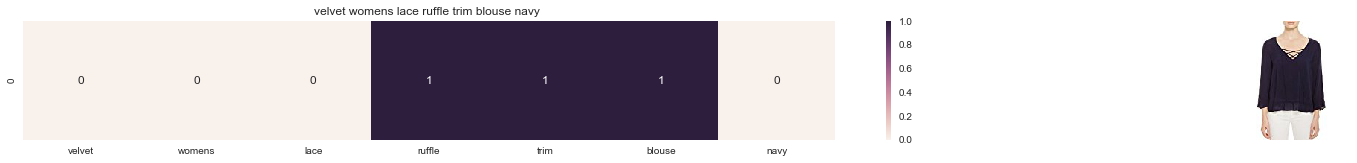

ASIN : B06XCZGQLP
Brand: Velvet by Graham & Spencer
Title: velvet womens lace ruffle trim blouse navy 
Euclidean similarity with the query image : 3.60555127546


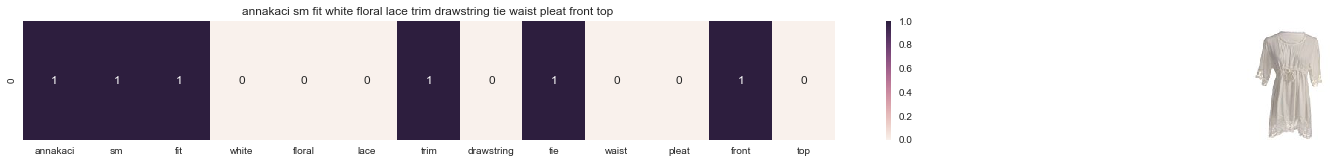

ASIN : B00DW1NKSS
Brand: Anna-Kaci
Title: annakaci sm fit white floral lace trim drawstring tie waist pleat front top 
Euclidean similarity with the query image : 3.60555127546


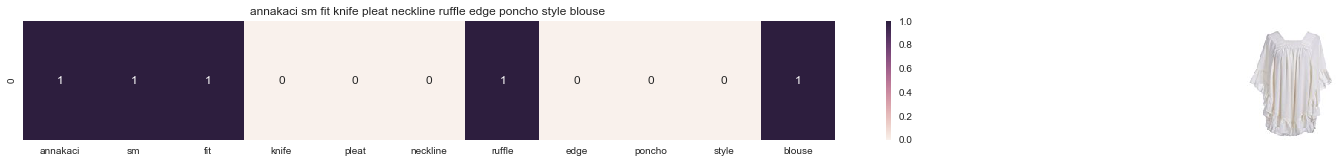

ASIN : B00HCNNOJW
Brand: Anna-Kaci
Title: annakaci sm fit knife pleat neckline ruffle edge poncho style blouse 
Euclidean similarity with the query image : 3.60555127546


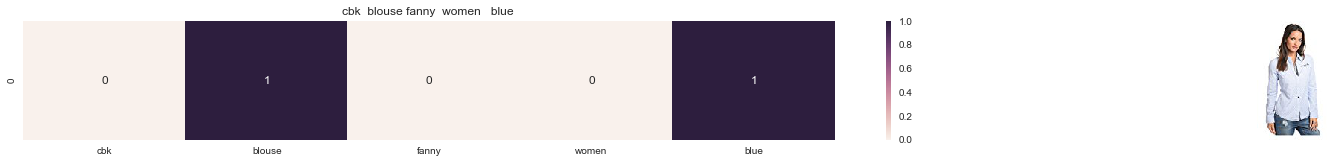

ASIN : B071NDX99J
Brand: CBK
Title: cbk  blouse fanny  women   blue 
Euclidean similarity with the query image : 3.60555127546


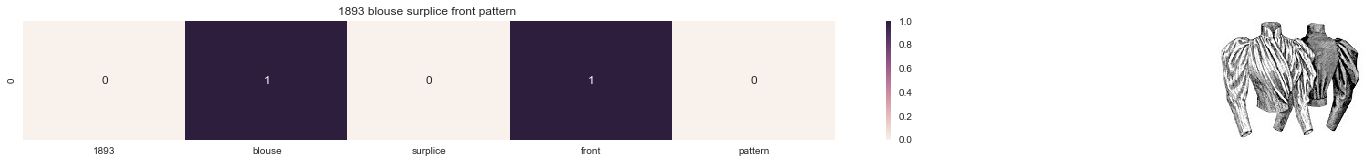

ASIN : B00886YXL0
Brand: Ageless Patterns
Title: 1893 blouse surplice front pattern 
Euclidean similarity with the query image : 3.60555127546


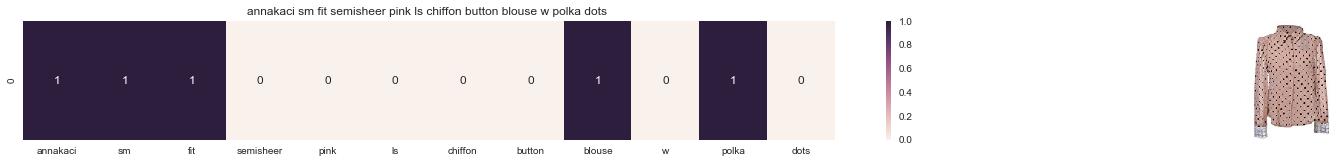

ASIN : B008Z5ST3C
Brand: Anna-Kaci
Title: annakaci sm fit semisheer pink ls chiffon button blouse w polka dots 
Euclidean similarity with the query image : 3.60555127546


In [14]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(931, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

## [8.5] TF-IDF based product similarity

In [15]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

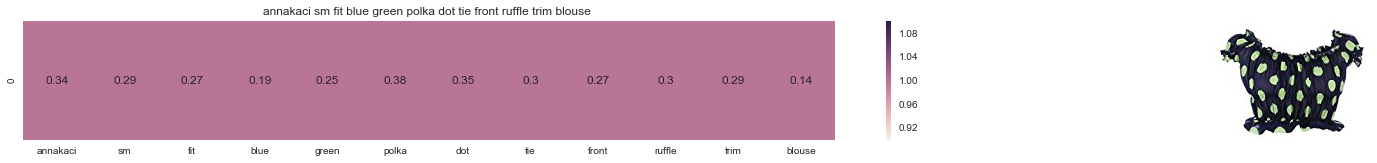

ASIN : B00KLHUIBS
BRAND : Anna-Kaci
Eucliden distance from the given image : 0.0


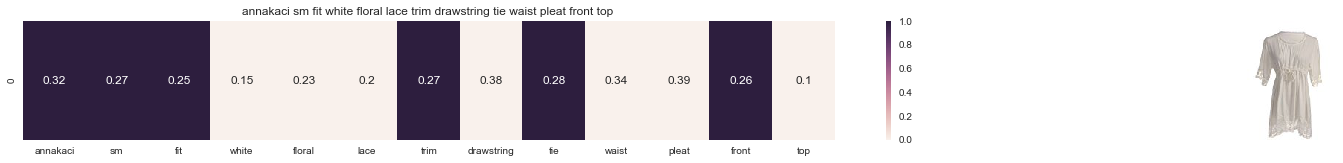

ASIN : B00DW1NKSS
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.00950304702


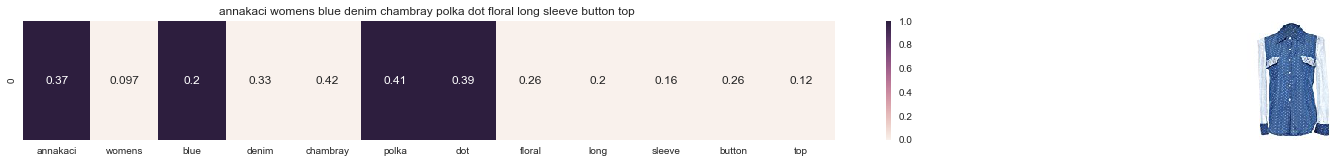

ASIN : B008SMIFN6
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.04179851203


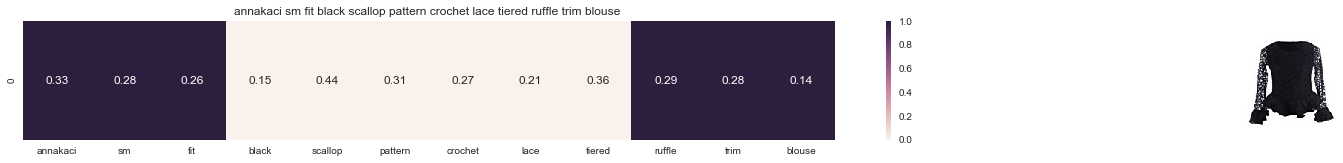

ASIN : B00O194W8W
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.04599047891


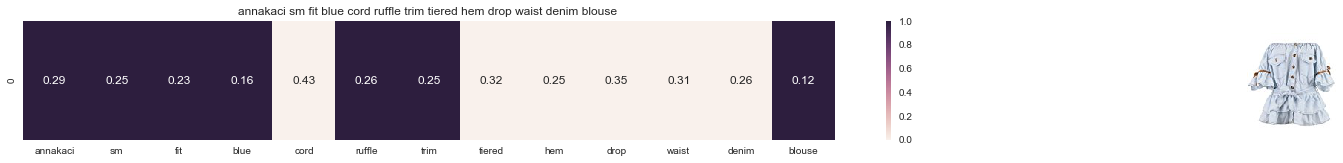

ASIN : B0759G15ZX
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.06703828913


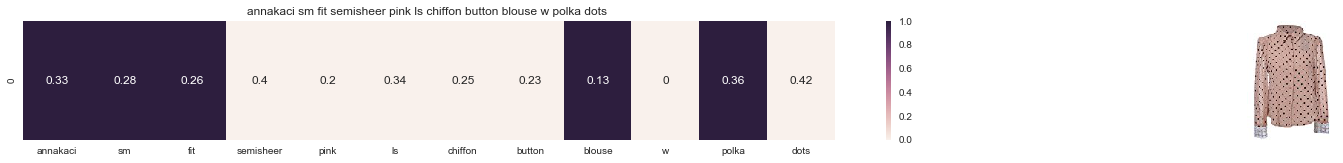

ASIN : B008Z5ST3C
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.07919434283


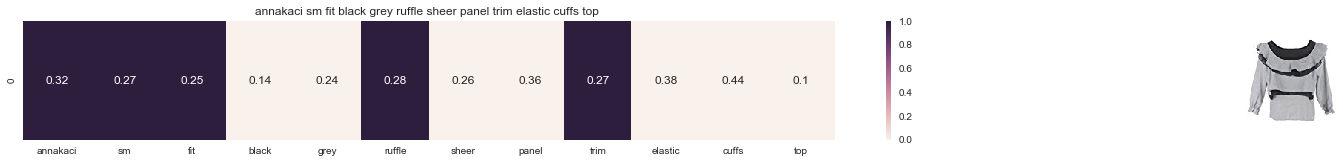

ASIN : B00OIBU11K
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.08106425475


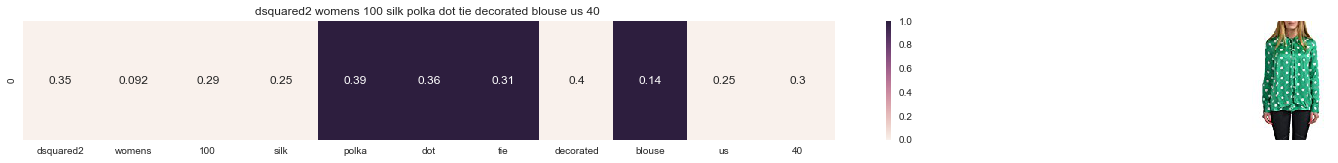

ASIN : B01AYBH28M
BRAND : DSQUARED2
Eucliden distance from the given image : 1.1040520792


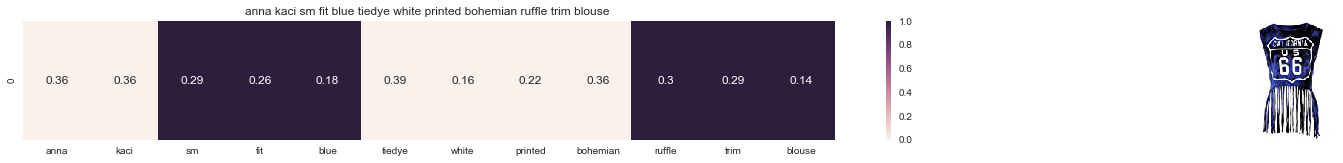

ASIN : B00YQ8S4K0
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.11063186696


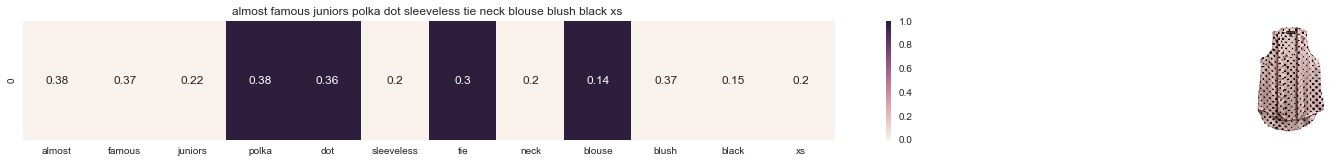

ASIN : B0745J9HNS
BRAND : Almost Famous
Eucliden distance from the given image : 1.11147843821


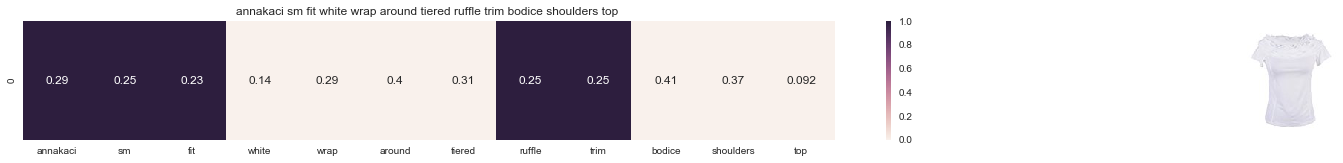

ASIN : B00LMKGFS8
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.11396339486


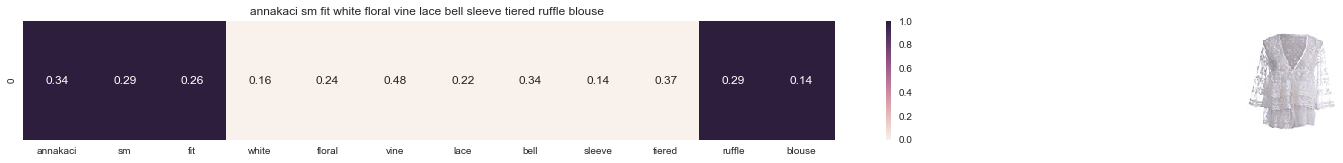

ASIN : B00DVOAWM8
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.11567061619


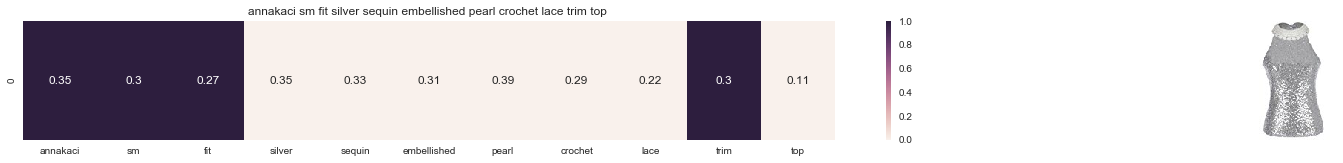

ASIN : B00OPFYBXI
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.12469756756


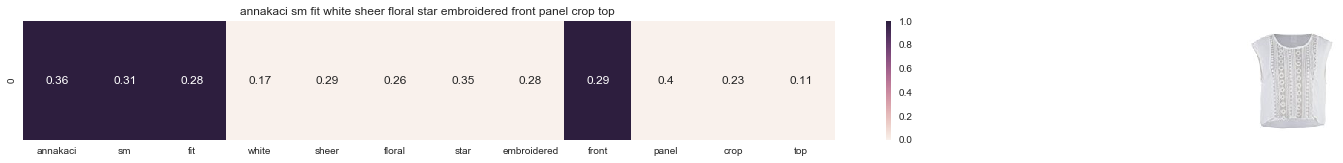

ASIN : B00NAB1R8A
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.12477388492


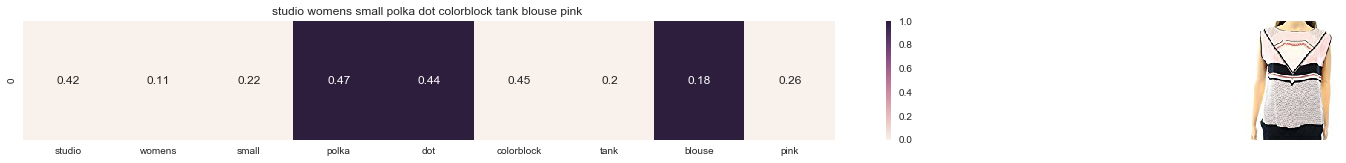

ASIN : B0721KC2HT
BRAND : Studio M
Eucliden distance from the given image : 1.12981638968


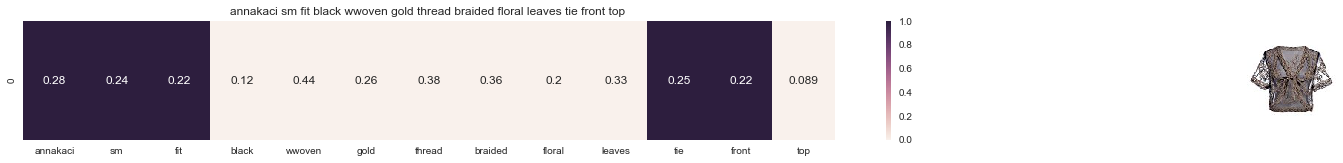

ASIN : B00E7Z8DWQ
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.13146940297


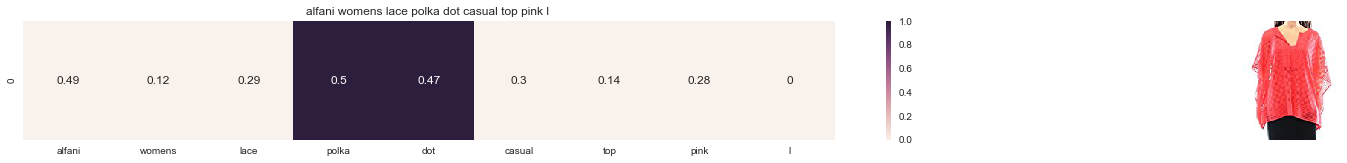

ASIN : B07125NJJ2
BRAND : Alfani
Eucliden distance from the given image : 1.13255450374


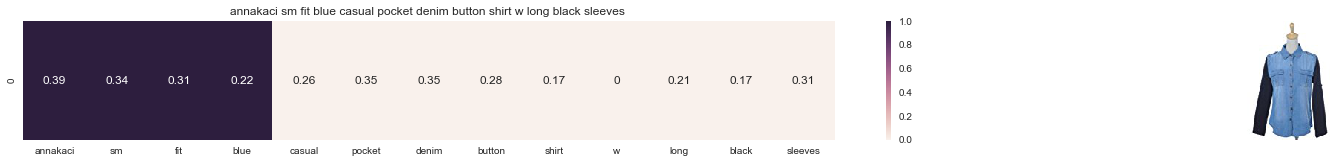

ASIN : B0097LQOOY
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.1344930102


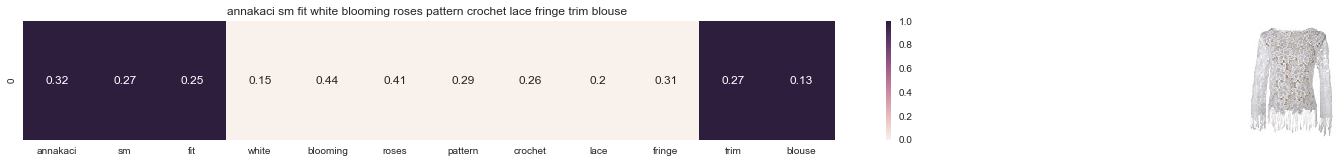

ASIN : B00RDLAR2A
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.13948889205


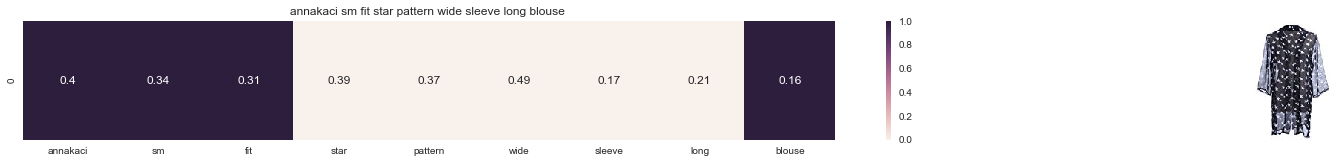

ASIN : B00G5RYY18
BRAND : Anna-Kaci
Eucliden distance from the given image : 1.14746607263


In [16]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(931, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

## [8.5] IDF based product similarity

In [17]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [18]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [19]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

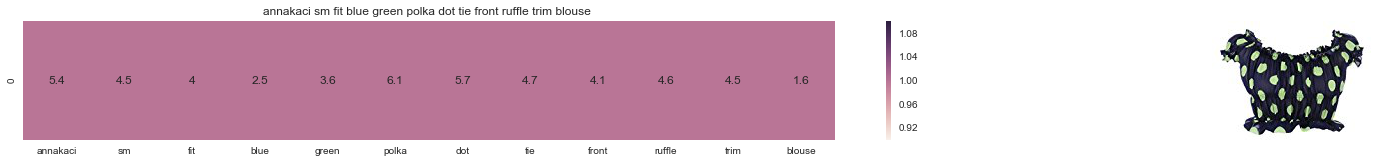

ASIN : B00KLHUIBS
Brand : Anna-Kaci
euclidean distance from the given image : 0.0


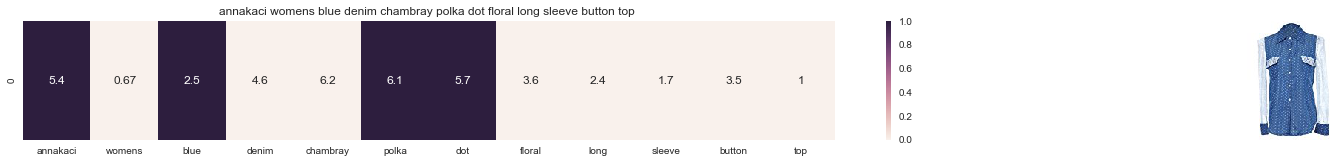

ASIN : B008SMIFN6
Brand : Anna-Kaci
euclidean distance from the given image : 15.0461517219


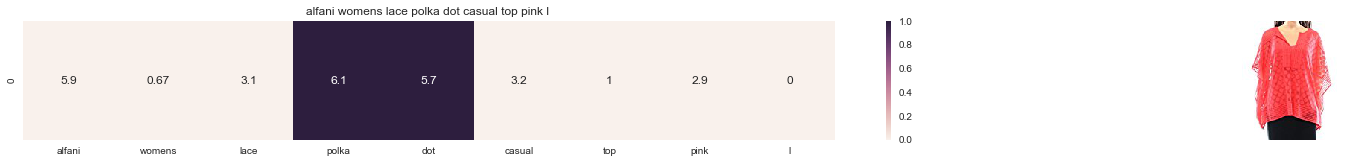

ASIN : B07125NJJ2
Brand : Alfani
euclidean distance from the given image : 15.2227692126


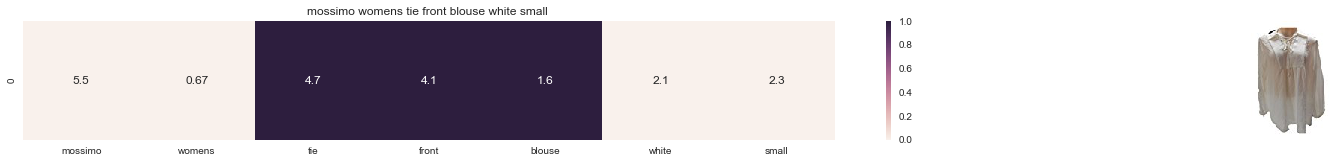

ASIN : B07111HHX6
Brand : Mossimo
euclidean distance from the given image : 15.3415518161


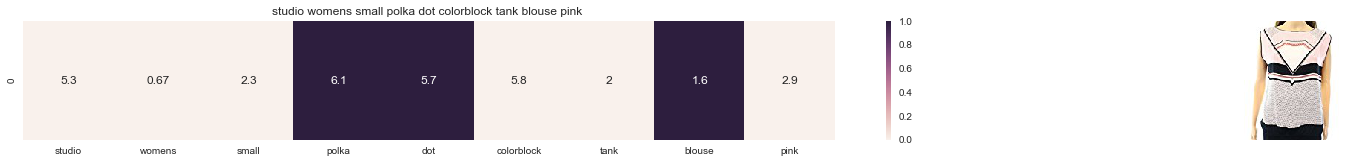

ASIN : B0721KC2HT
Brand : Studio M
euclidean distance from the given image : 15.6273492768


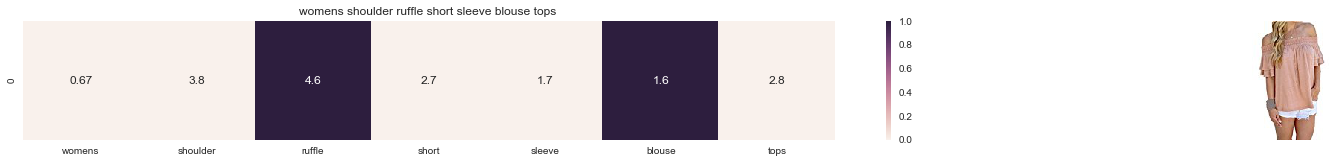

ASIN : B01KXEE20Q
Brand : ouwoow
euclidean distance from the given image : 15.6852492098


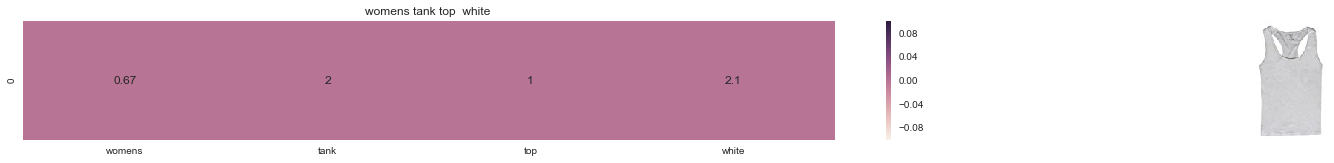

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 15.698624105


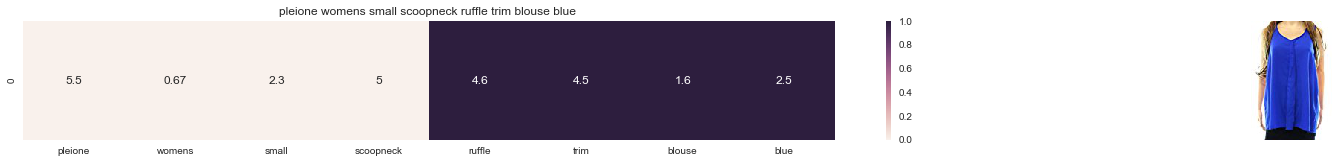

ASIN : B072VHTT1D
Brand : Pleione
euclidean distance from the given image : 15.7331591645


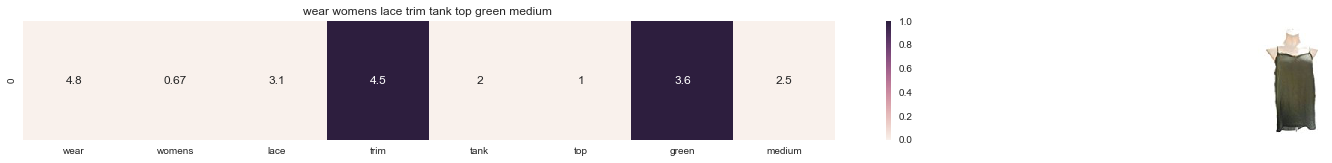

ASIN : B0722TS9DK
Brand : Who What Wear
euclidean distance from the given image : 15.7465196421


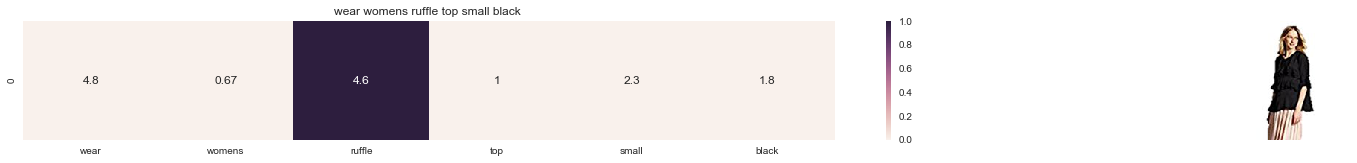

ASIN : B07258X2FK
Brand : Who What Wear
euclidean distance from the given image : 15.7686165877


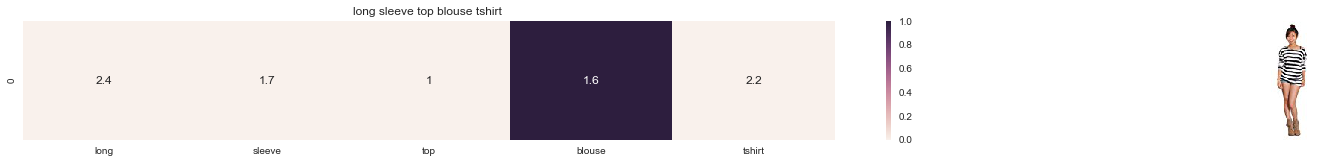

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 15.7695707276


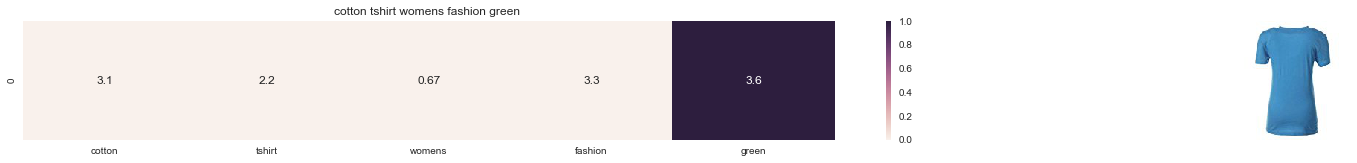

ASIN : B073GJGVBN
Brand : Ivan Levi
euclidean distance from the given image : 15.8115628216


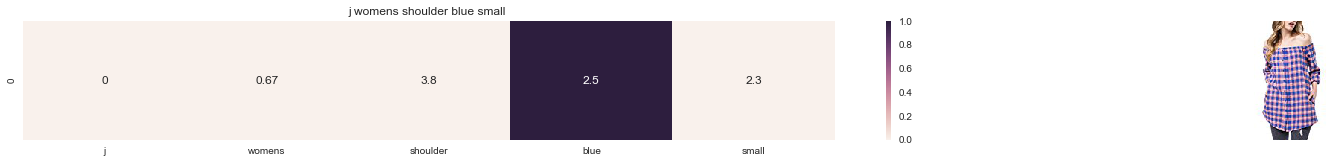

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 15.8382805474


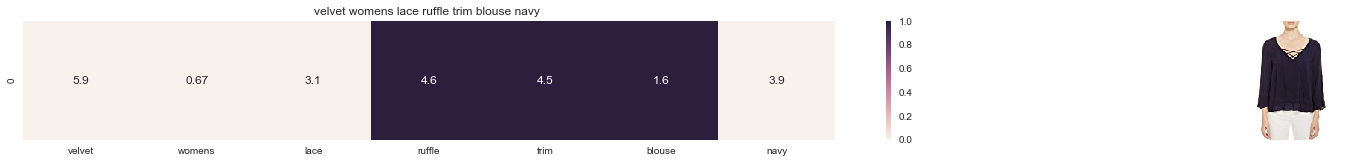

ASIN : B06XCZGQLP
Brand : Velvet by Graham & Spencer
euclidean distance from the given image : 15.8787817852


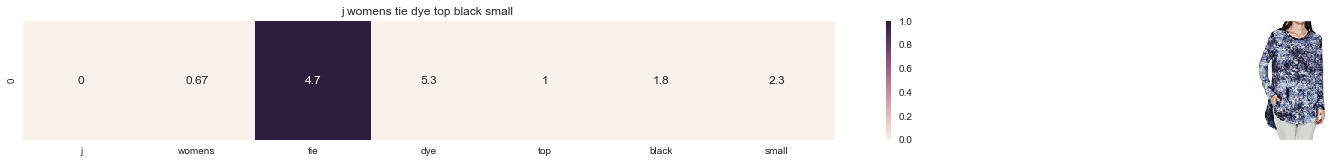

ASIN : B075831F14
Brand : Very J
euclidean distance from the given image : 15.9287497594


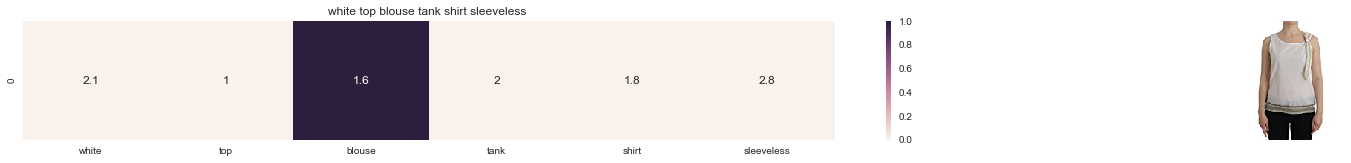

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 15.953279501


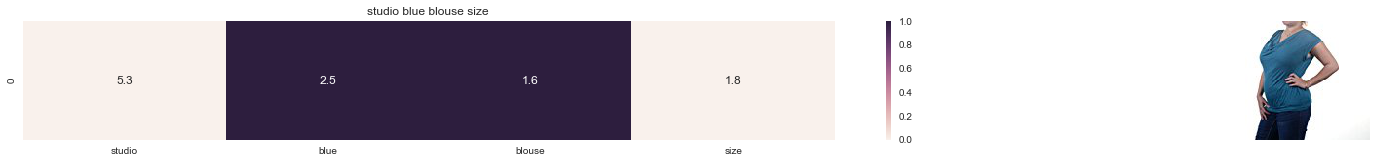

ASIN : B016P80OKQ
Brand : Studio M
euclidean distance from the given image : 16.0788232455


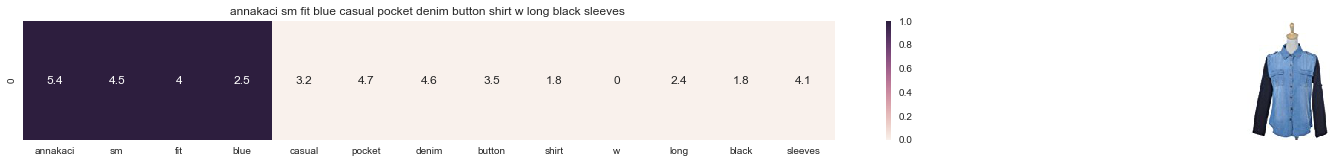

ASIN : B0097LQOOY
Brand : Anna-Kaci
euclidean distance from the given image : 16.1197816394


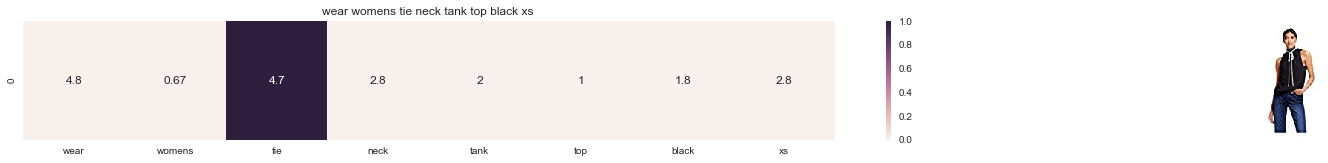

ASIN : B071RYB16J
Brand : Who What Wear
euclidean distance from the given image : 16.1899275793


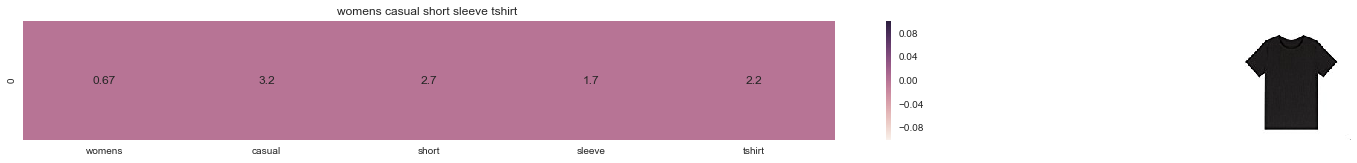

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 16.2025592308


In [20]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(931,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

# [9] Text Semantics based product similarity

In [21]:

# credits: https://www.kaggle.com/c/word2vec-nlp-tutorial#part-2-word-vectors
# Custom Word2Vec using your own text data.
# Do NOT RUN this code.
# It is meant as a reference to build your own Word2Vec when you have 
# lots of data.

'''
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sen_corpus, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
    
'''

'\n# Set values for various parameters\nnum_features = 300    # Word vector dimensionality                      \nmin_word_count = 1    # Minimum word count                        \nnum_workers = 4       # Number of threads to run in parallel\ncontext = 10          # Context window size                                                                                    \ndownsampling = 1e-3   # Downsample setting for frequent words\n\n# Initialize and train the model (this will take some time)\nfrom gensim.models import word2vec\nprint ("Training model...")\nmodel = word2vec.Word2Vec(sen_corpus, workers=num_workers,             size=num_features, min_count = min_word_count,             window = context)\n    \n'

In [22]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [23]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [24]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

### [9.2] Average Word2Vec product similarity.

In [25]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


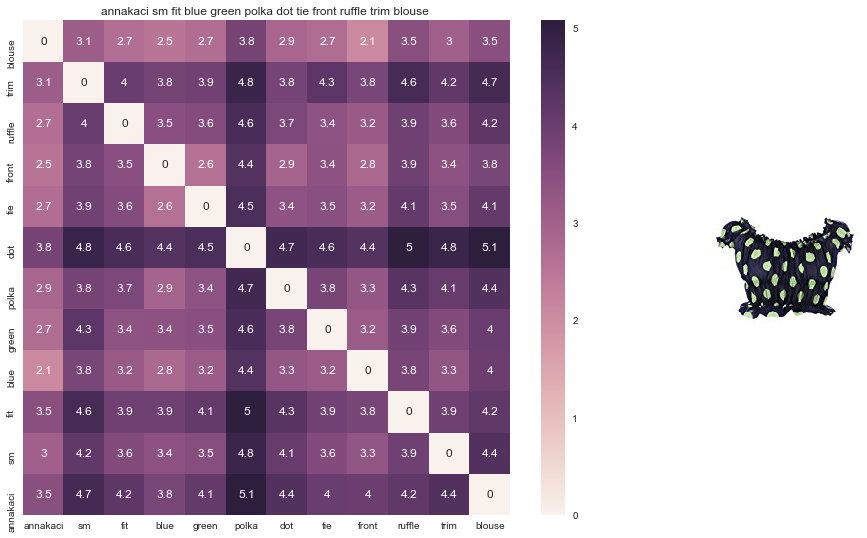

ASIN : B00KLHUIBS
BRAND : Anna-Kaci
euclidean distance from given input image : 0.0


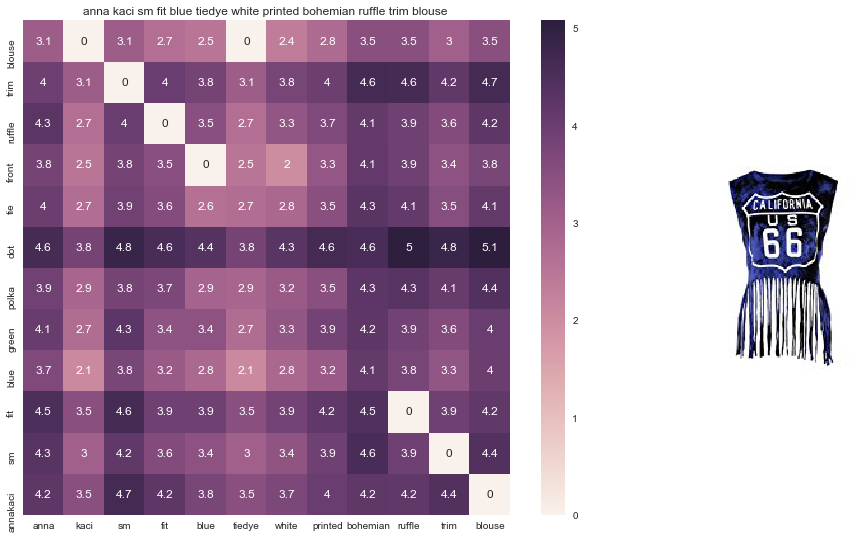

ASIN : B00YQ8S4K0
BRAND : Anna-Kaci
euclidean distance from given input image : 0.669069


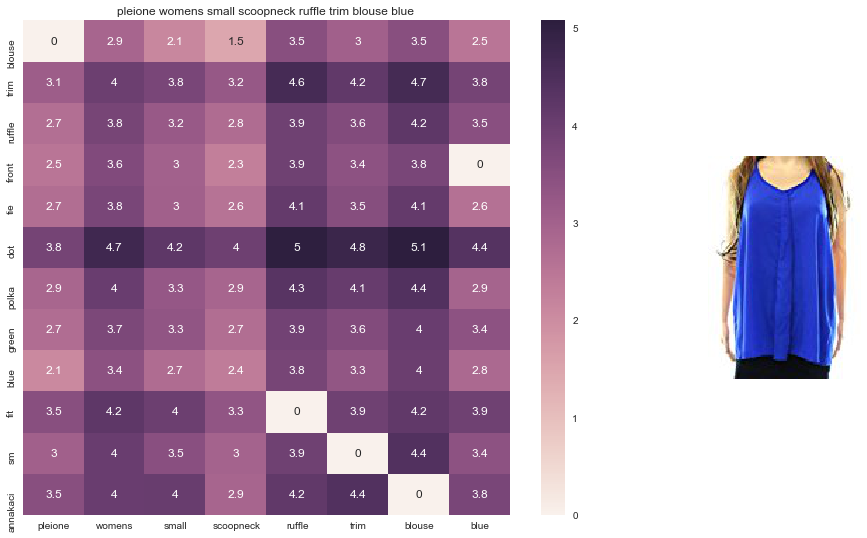

ASIN : B072VHTT1D
BRAND : Pleione
euclidean distance from given input image : 0.791767


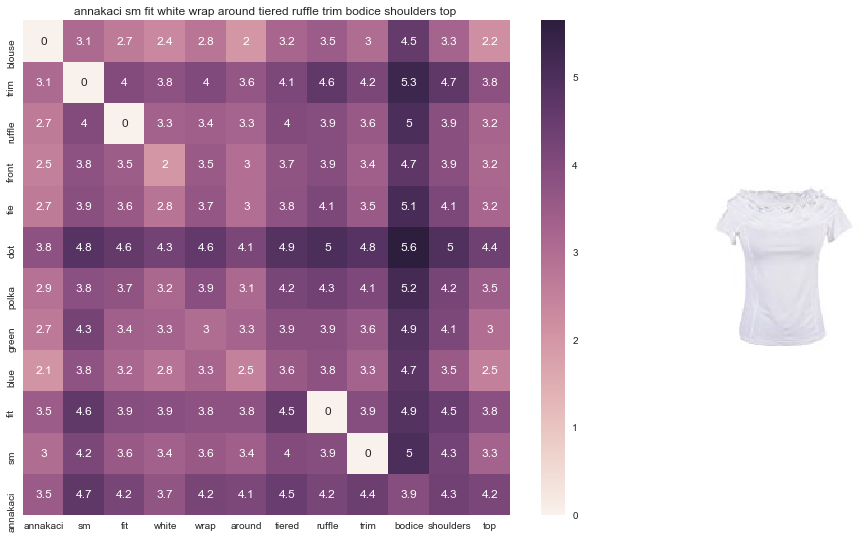

ASIN : B00LMKGFS8
BRAND : Anna-Kaci
euclidean distance from given input image : 0.809423


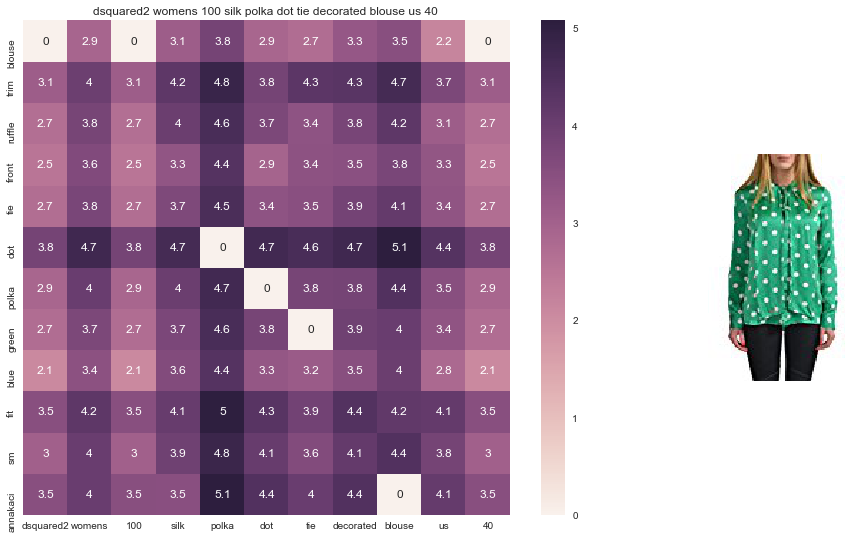

ASIN : B01AYBH28M
BRAND : DSQUARED2
euclidean distance from given input image : 0.812742


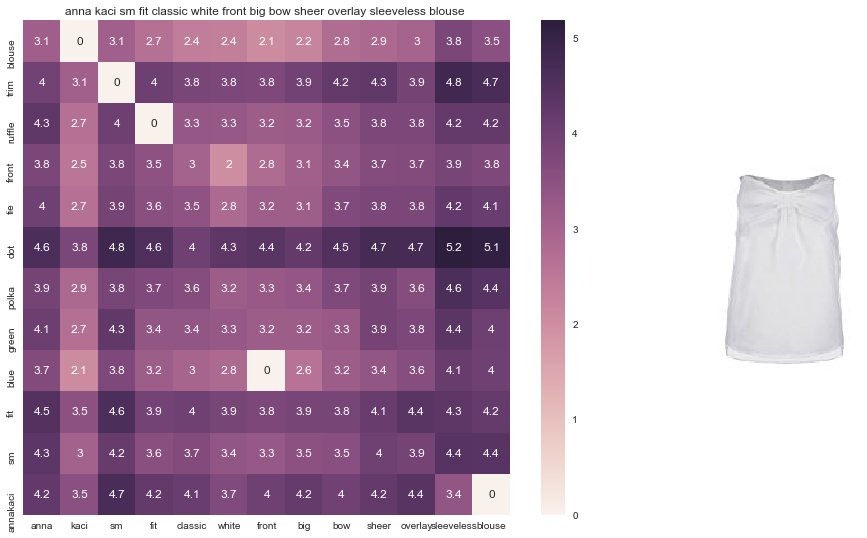

ASIN : B010EH3S02
BRAND : Anna-Kaci
euclidean distance from given input image : 0.818817


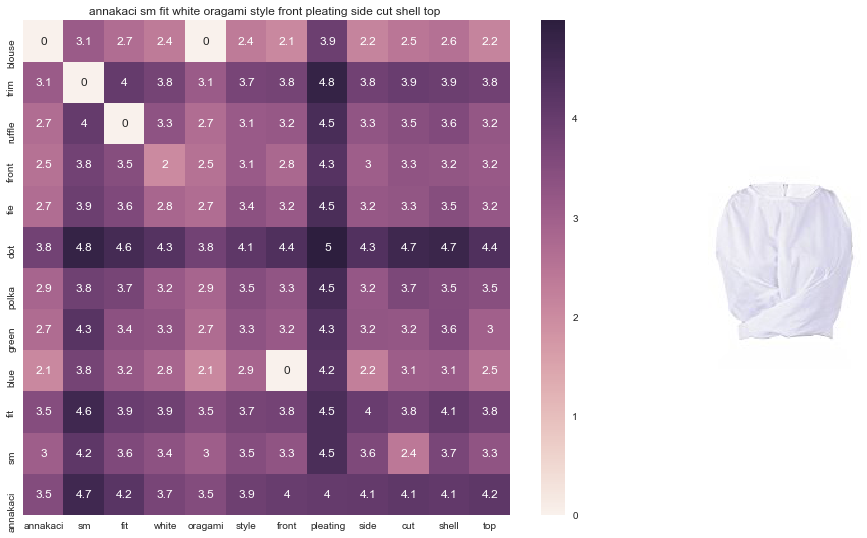

ASIN : B00LU4Z2YY
BRAND : Anna-Kaci
euclidean distance from given input image : 0.819001


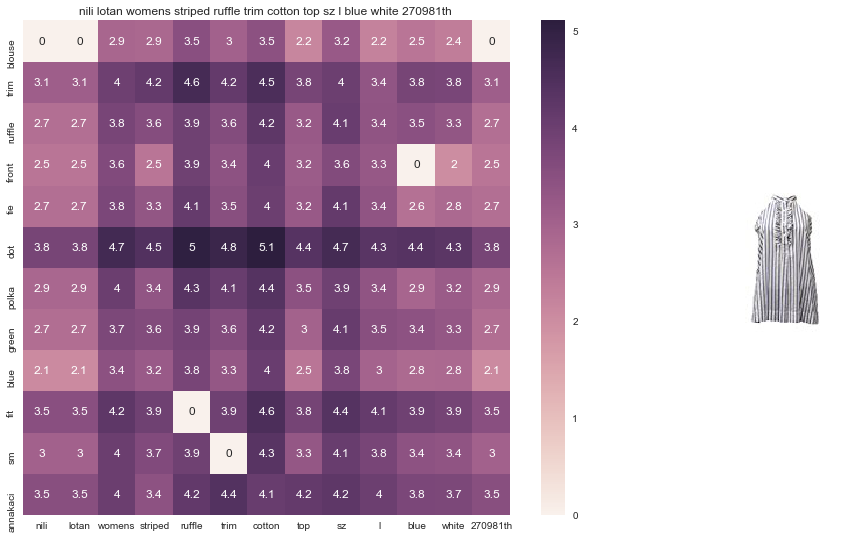

ASIN : B074PFR9CF
BRAND : Nili Lotan
euclidean distance from given input image : 0.821753


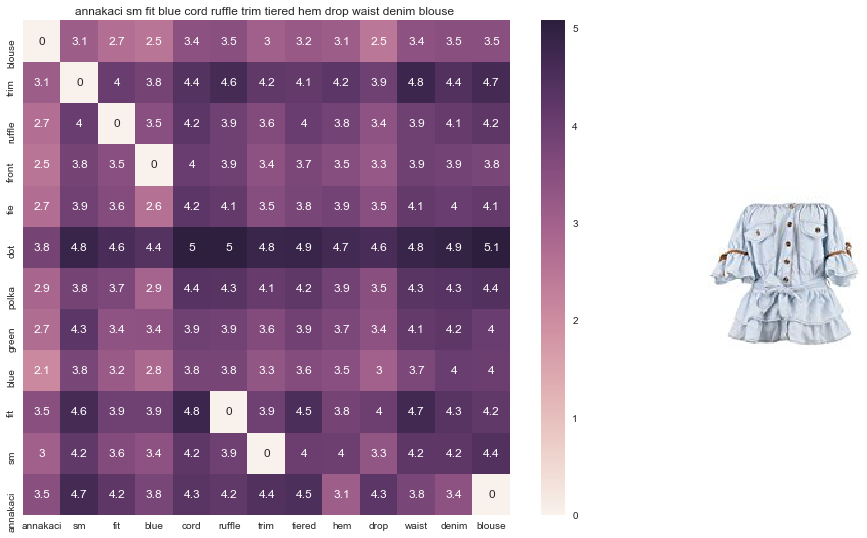

ASIN : B0759G15ZX
BRAND : Anna-Kaci
euclidean distance from given input image : 0.826781


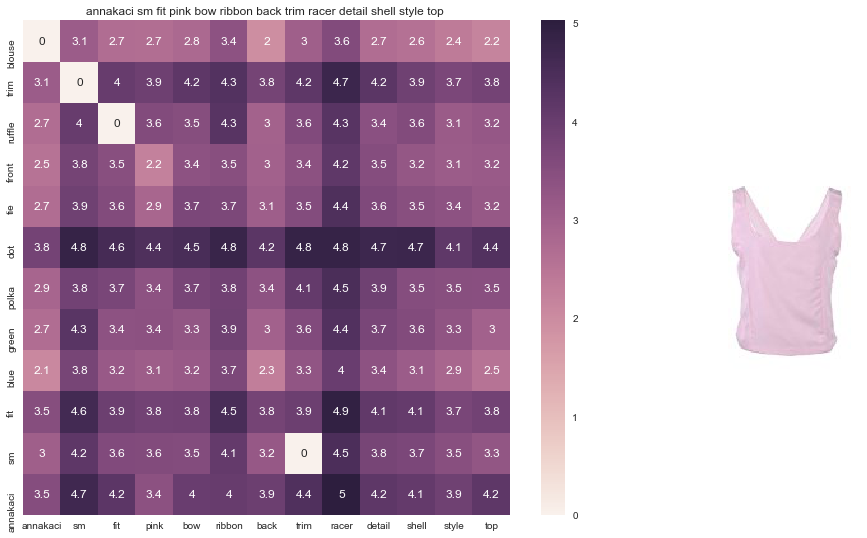

ASIN : B00KOBQEBO
BRAND : Anna-Kaci
euclidean distance from given input image : 0.826844


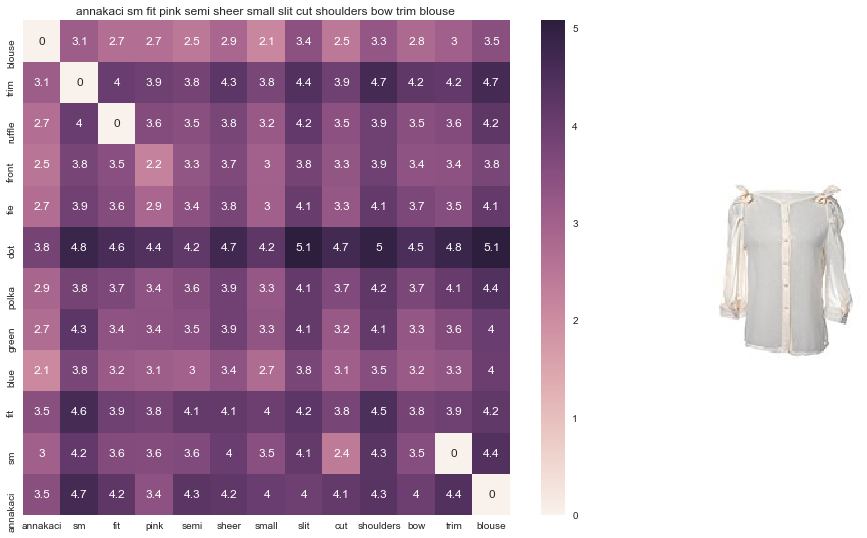

ASIN : B00HM9OD8W
BRAND : Anna-Kaci
euclidean distance from given input image : 0.827371


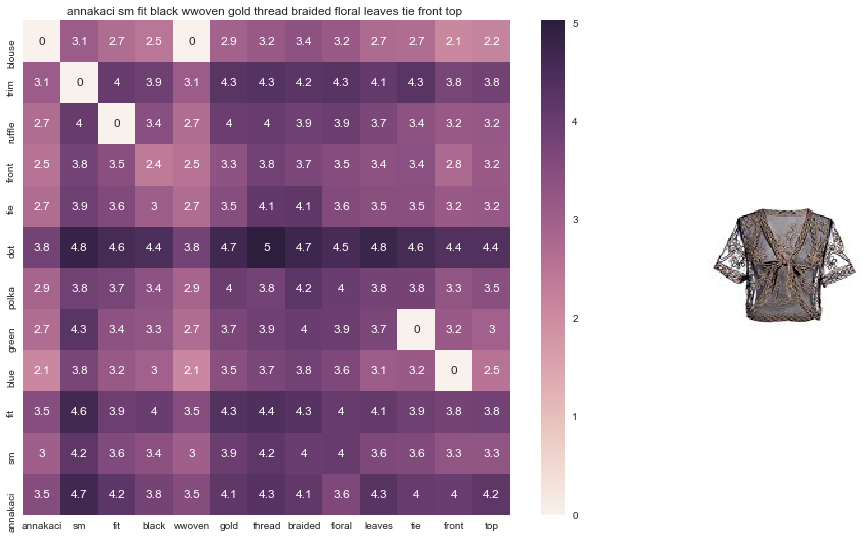

ASIN : B00E7Z8DWQ
BRAND : Anna-Kaci
euclidean distance from given input image : 0.8279


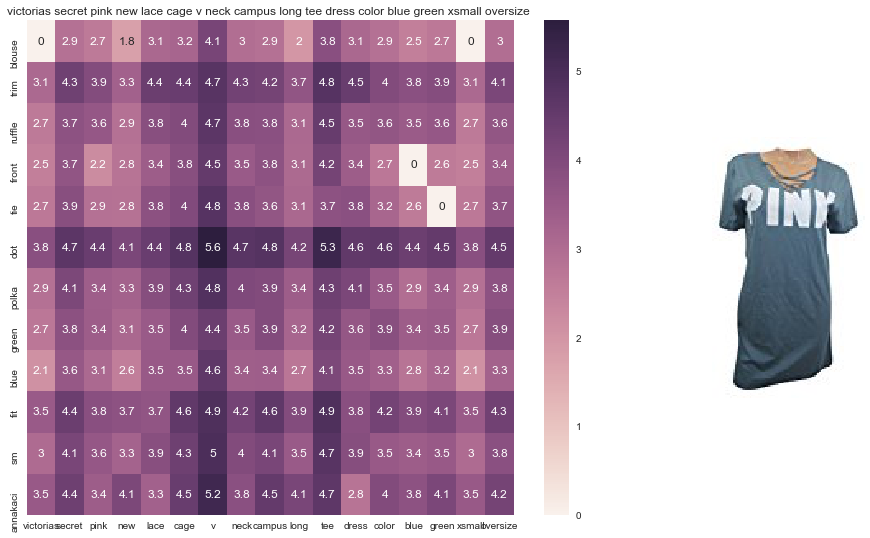

ASIN : B074JKJHNQ
BRAND : VS Pink
euclidean distance from given input image : 0.833093


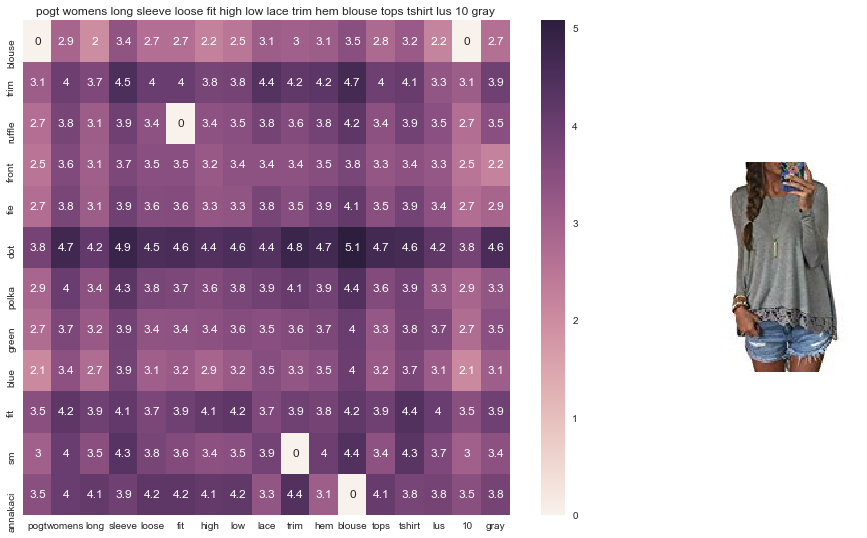

ASIN : B01M19NC0Y
BRAND : POGT
euclidean distance from given input image : 0.835796


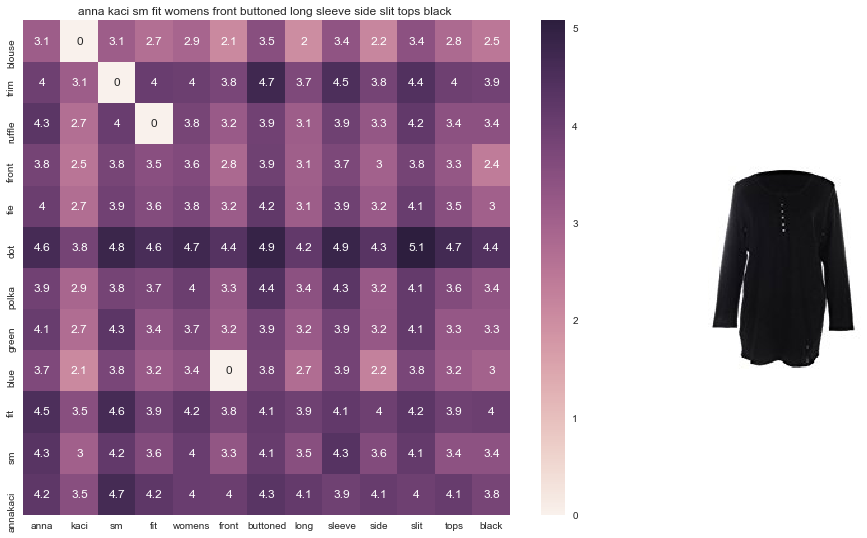

ASIN : B019820A4Q
BRAND : Anna-Kaci
euclidean distance from given input image : 0.842963


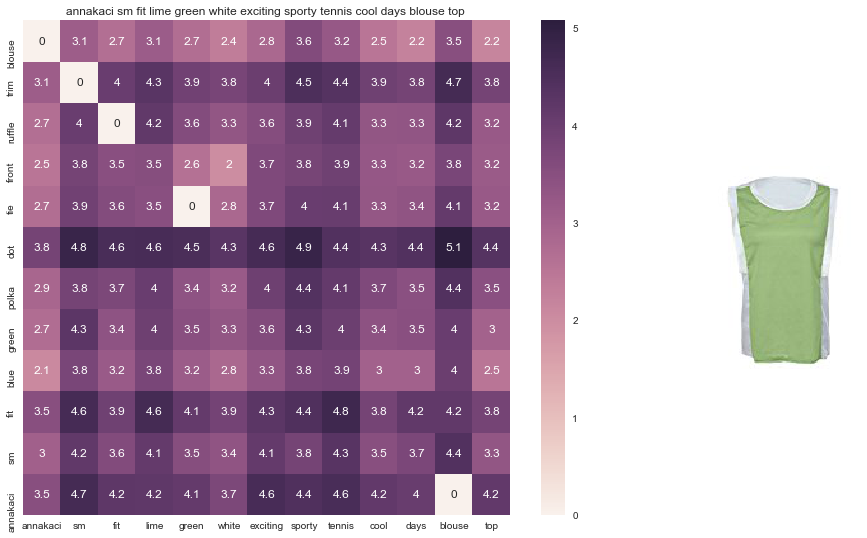

ASIN : B007Y9SZSY
BRAND : Anna-Kaci
euclidean distance from given input image : 0.843245


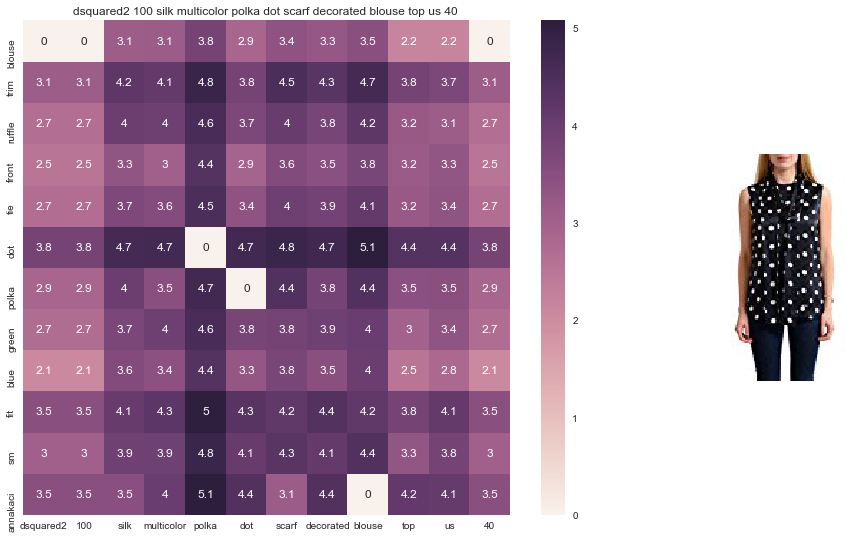

ASIN : B01D6FVFH2
BRAND : DSQUARED2
euclidean distance from given input image : 0.845249


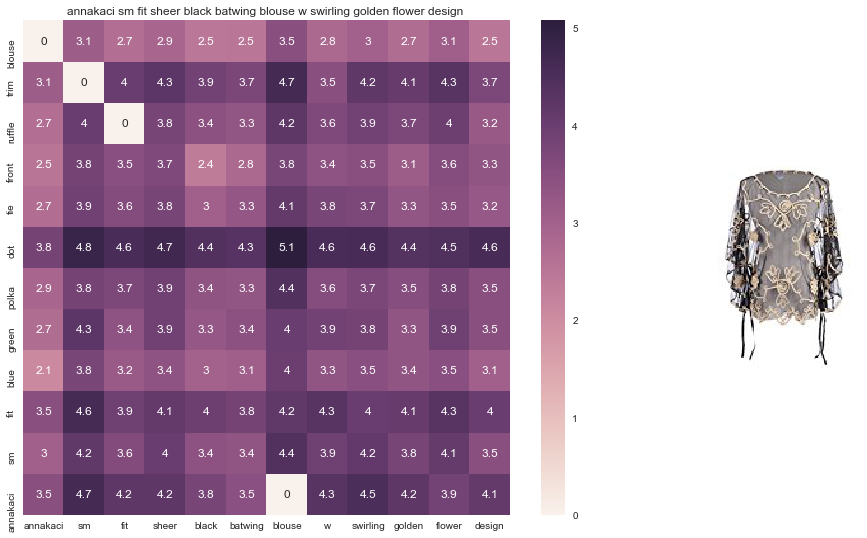

ASIN : B008LE9GA2
BRAND : Anna-Kaci
euclidean distance from given input image : 0.848137


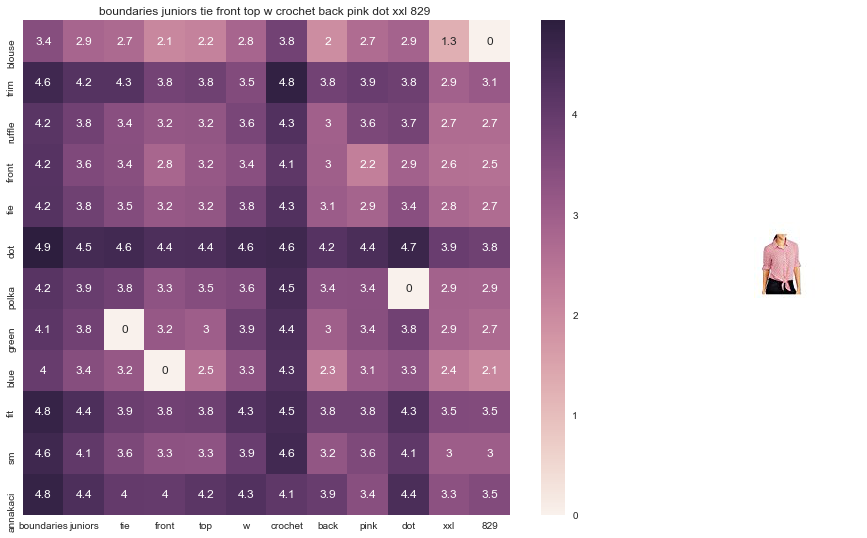

ASIN : B01JCZWOUW
BRAND : No Boundaries
euclidean distance from given input image : 0.848844


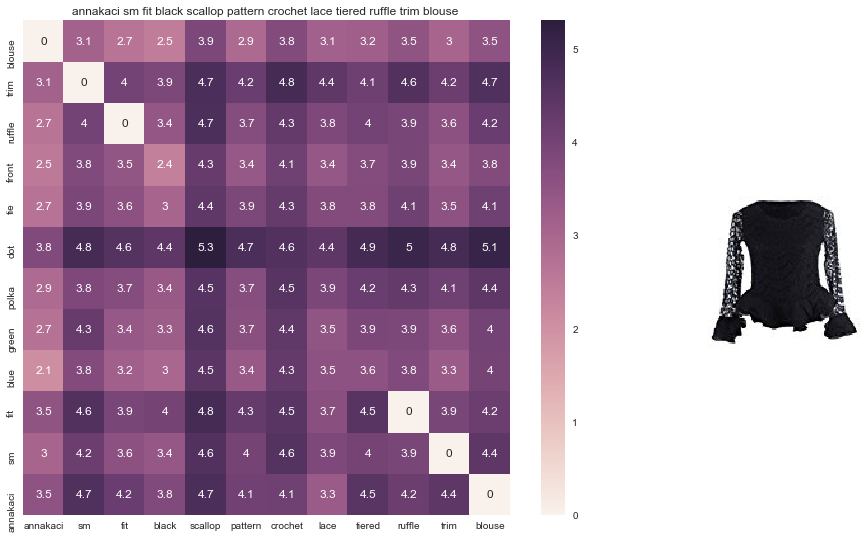

ASIN : B00O194W8W
BRAND : Anna-Kaci
euclidean distance from given input image : 0.849815


In [26]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(931, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

### [9.4]  IDF weighted Word2Vec for product similarity

In [27]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

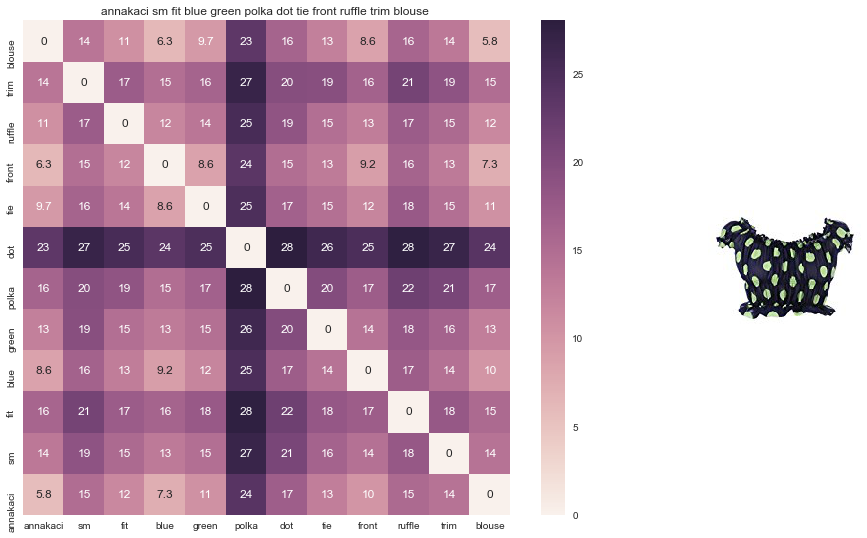

ASIN : B00KLHUIBS
Brand : Anna-Kaci
euclidean distance from input : 0.0


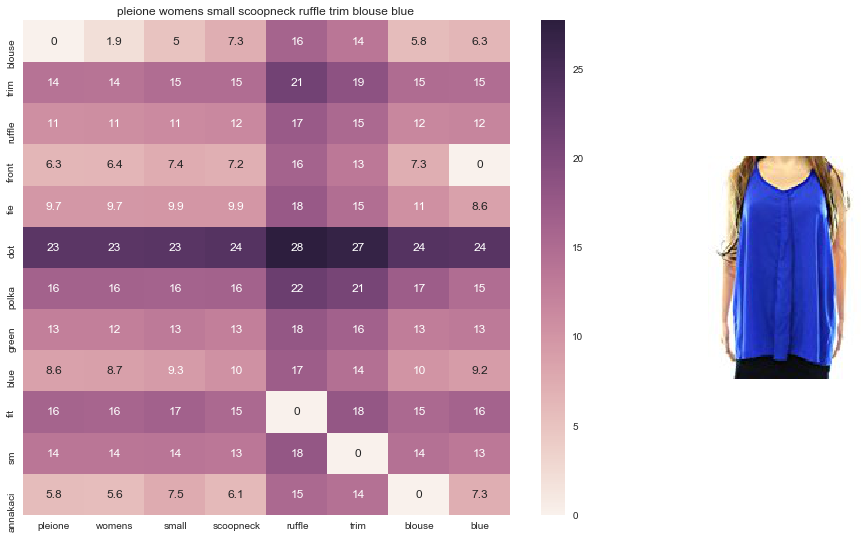

ASIN : B072VHTT1D
Brand : Pleione
euclidean distance from input : 3.30462


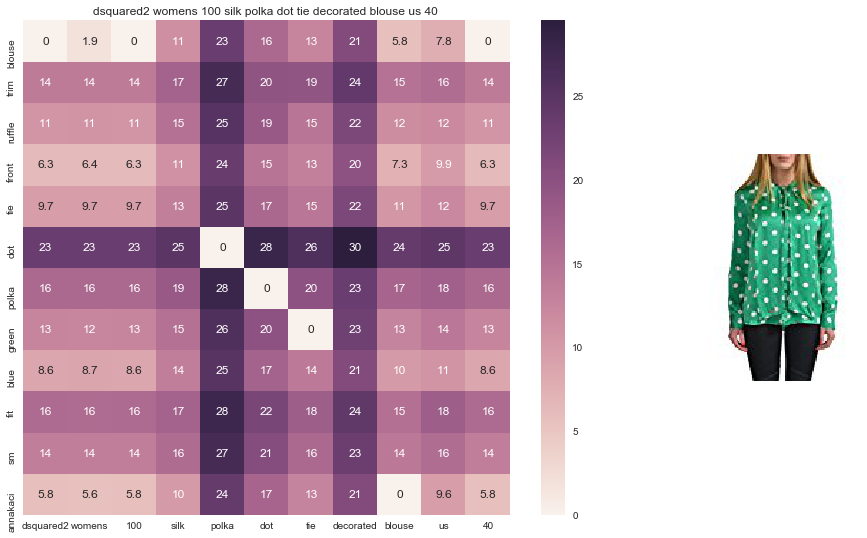

ASIN : B01AYBH28M
Brand : DSQUARED2
euclidean distance from input : 3.37033


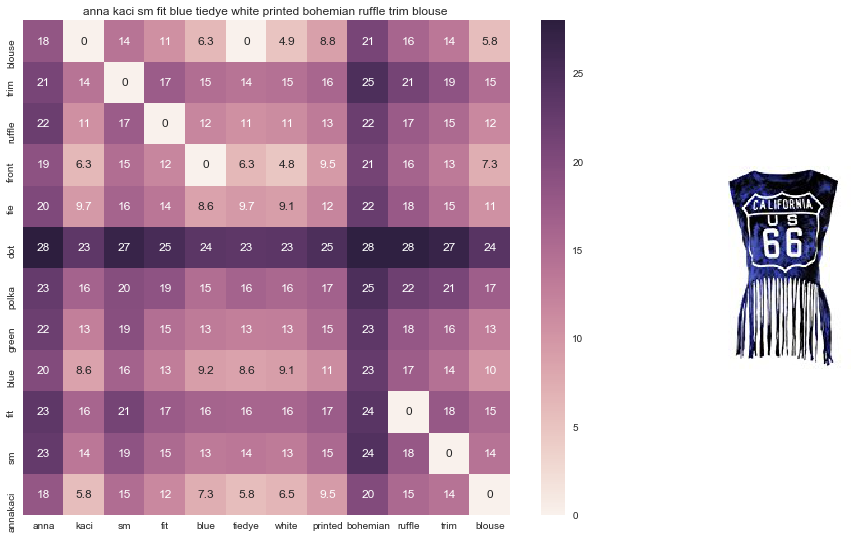

ASIN : B00YQ8S4K0
Brand : Anna-Kaci
euclidean distance from input : 3.41935


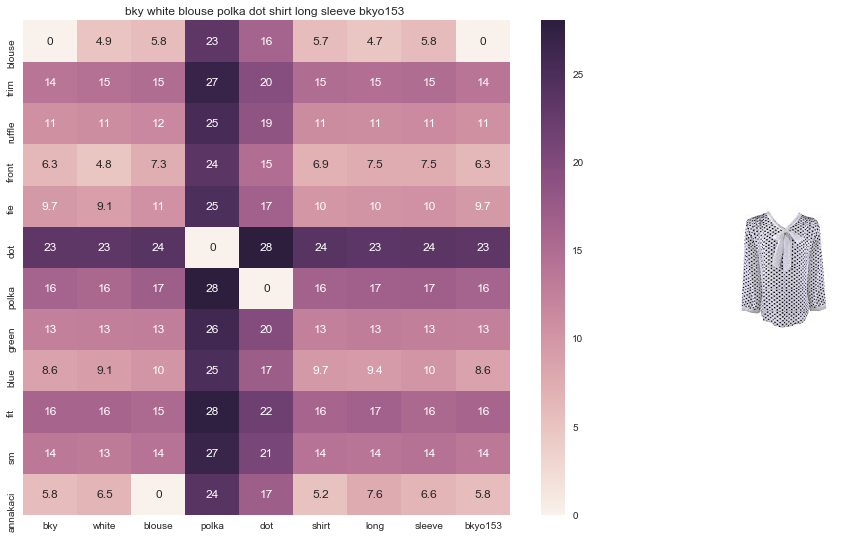

ASIN : B00ZD1LI16
Brand : bankhunyabangyai store
euclidean distance from input : 3.4256


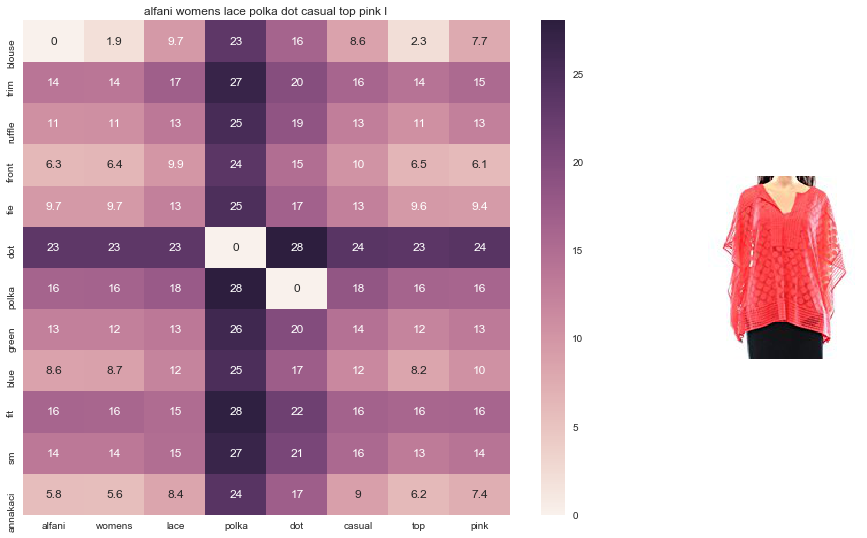

ASIN : B07125NJJ2
Brand : Alfani
euclidean distance from input : 3.44062


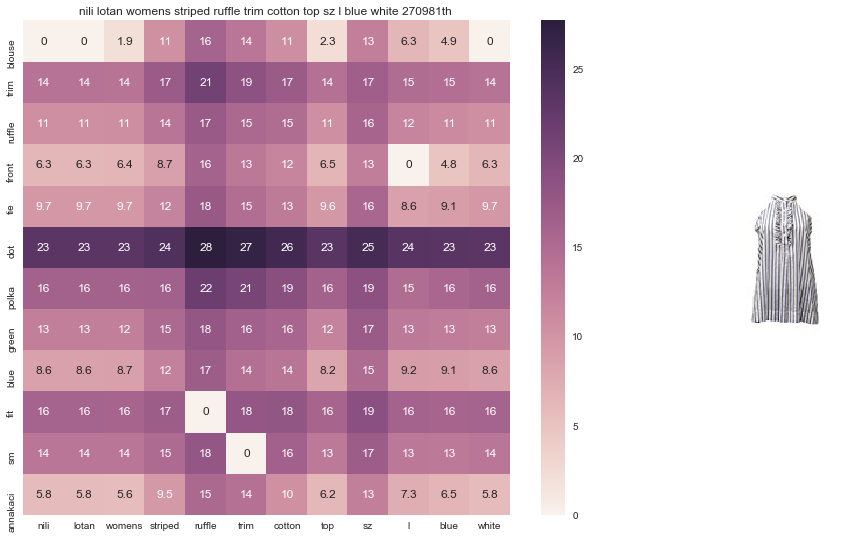

ASIN : B074PFR9CF
Brand : Nili Lotan
euclidean distance from input : 3.54702


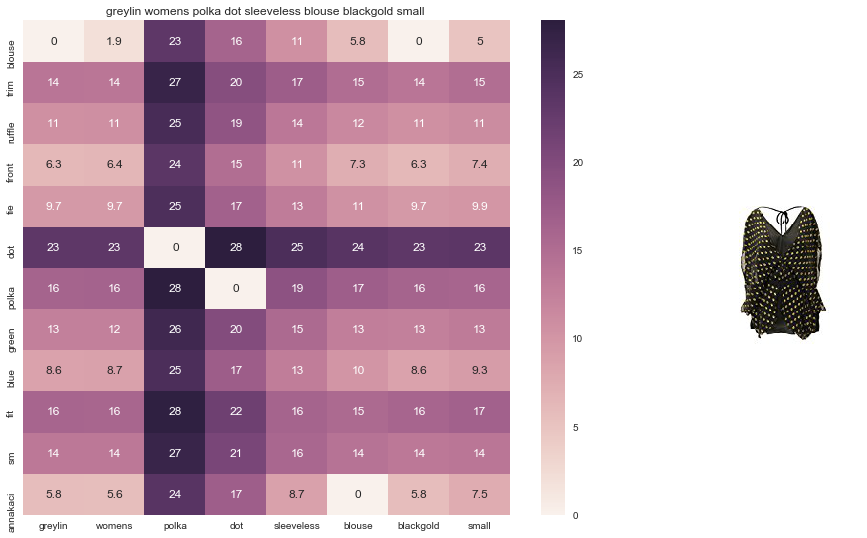

ASIN : B0725BZ69R
Brand : Greylin
euclidean distance from input : 3.57015


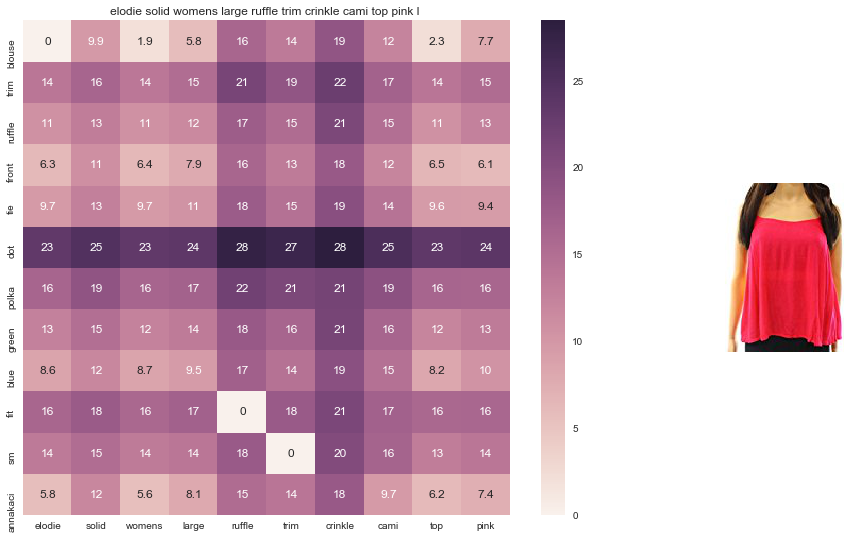

ASIN : B071XHZ2N2
Brand : Elodie
euclidean distance from input : 3.64684


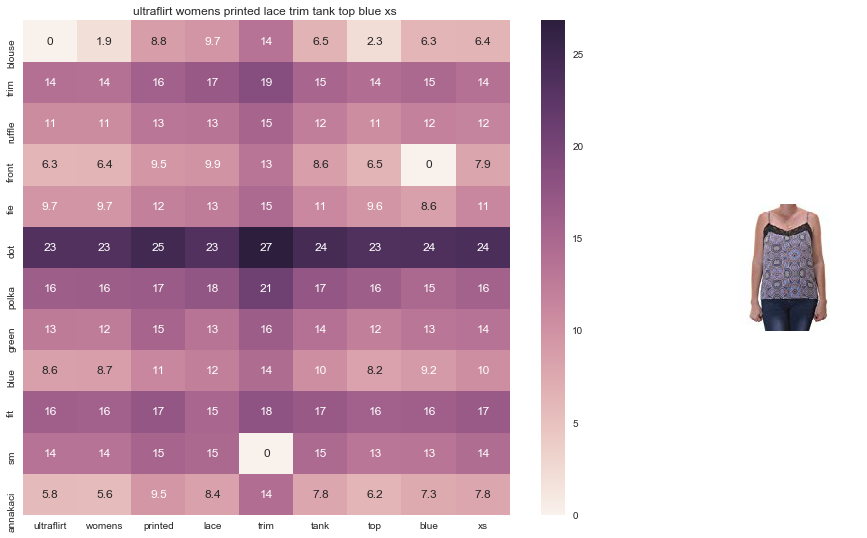

ASIN : B014JS4NIS
Brand : Ultra Flirt
euclidean distance from input : 3.65271


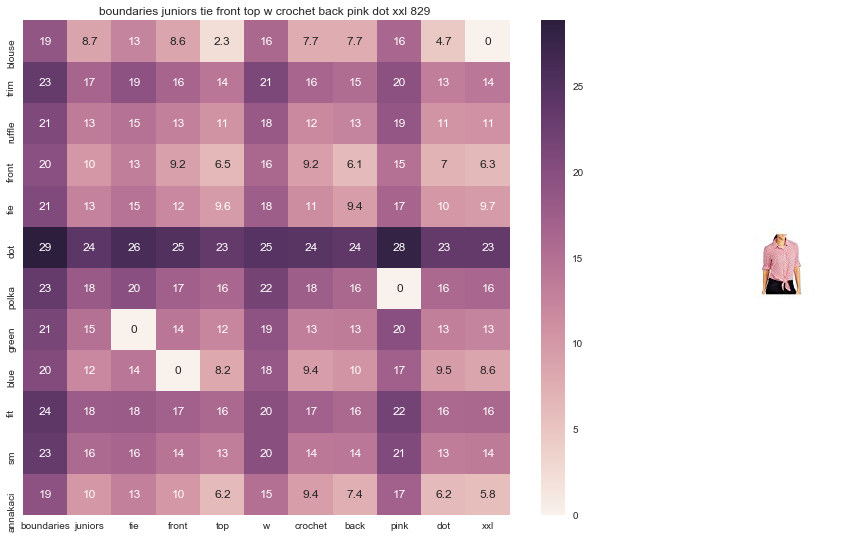

ASIN : B01JCZWOUW
Brand : No Boundaries
euclidean distance from input : 3.65771


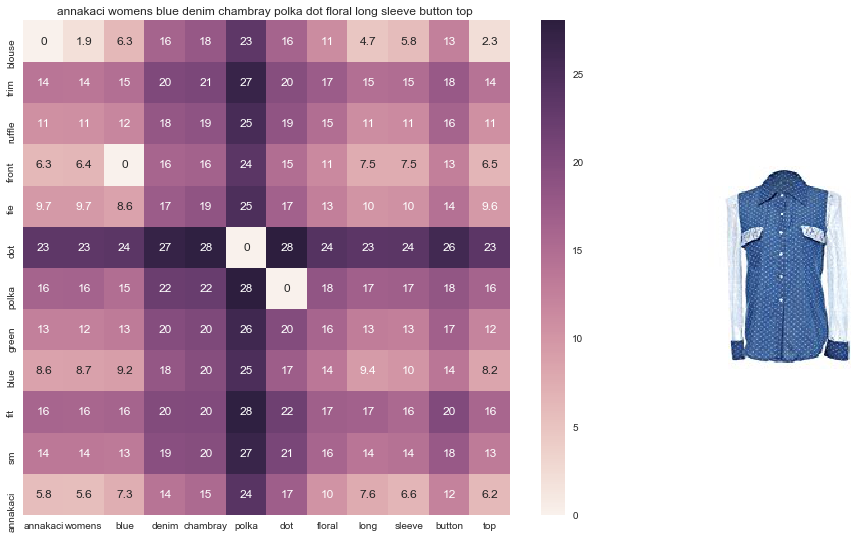

ASIN : B008SMIFN6
Brand : Anna-Kaci
euclidean distance from input : 3.68226


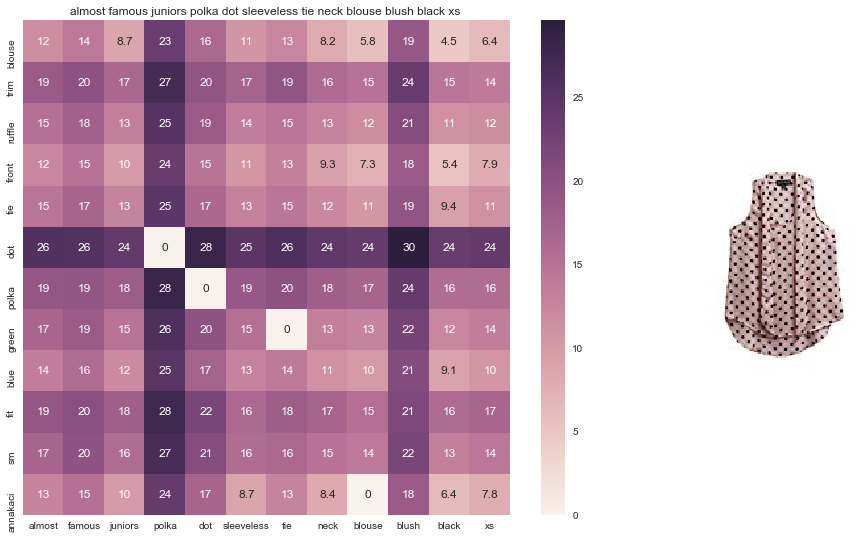

ASIN : B0745J9HNS
Brand : Almost Famous
euclidean distance from input : 3.71609


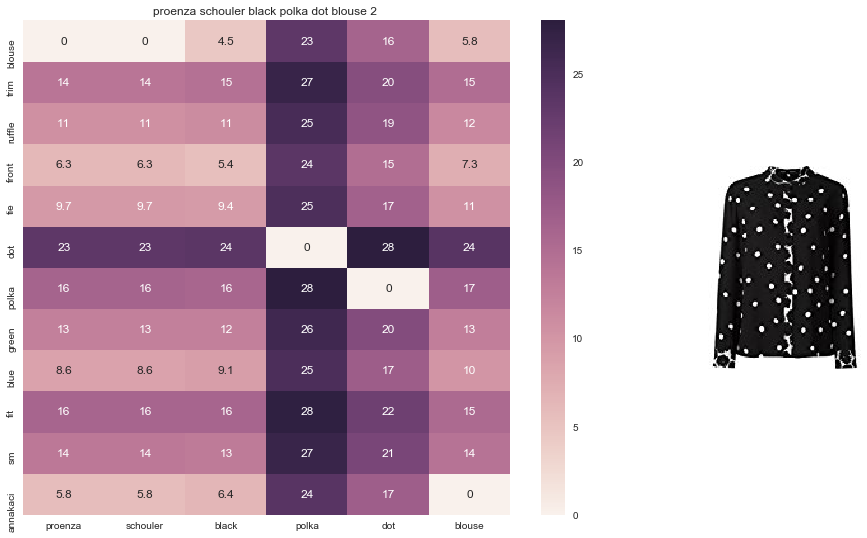

ASIN : B074TLHLMN
Brand : Proenza Schouler
euclidean distance from input : 3.72181


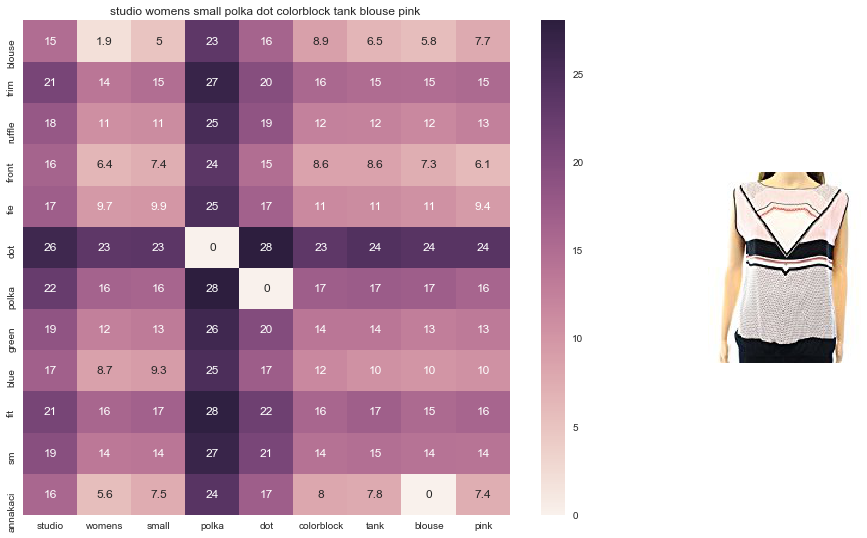

ASIN : B0721KC2HT
Brand : Studio M
euclidean distance from input : 3.74076


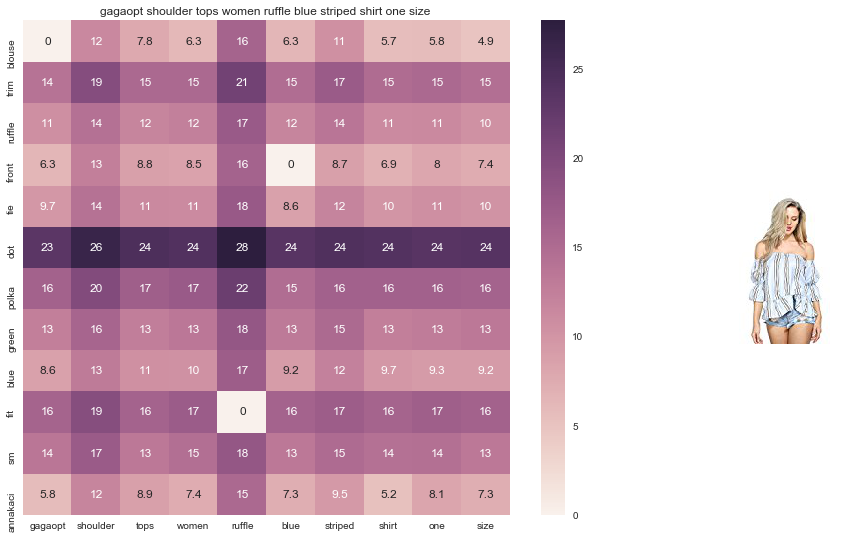

ASIN : B0731KJL5J
Brand : gagaopt
euclidean distance from input : 3.75304


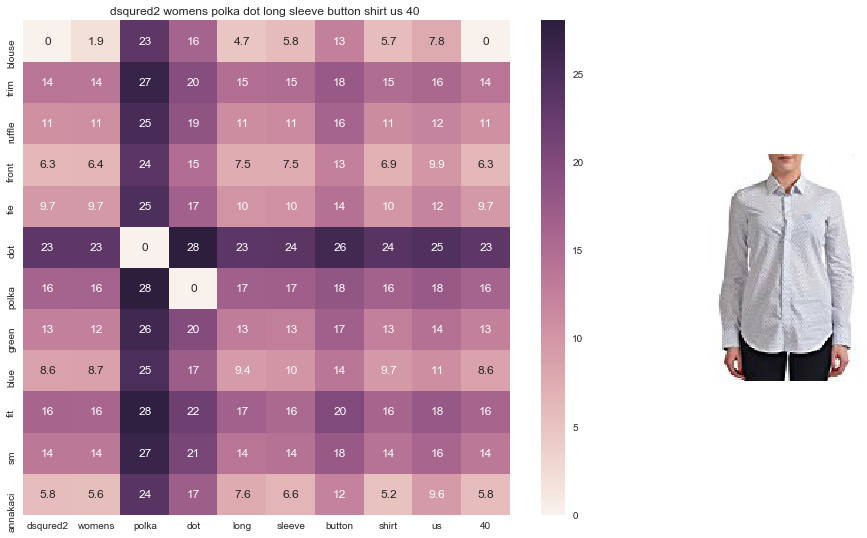

ASIN : B01APYN5AM
Brand : DSQUARED2
euclidean distance from input : 3.77084


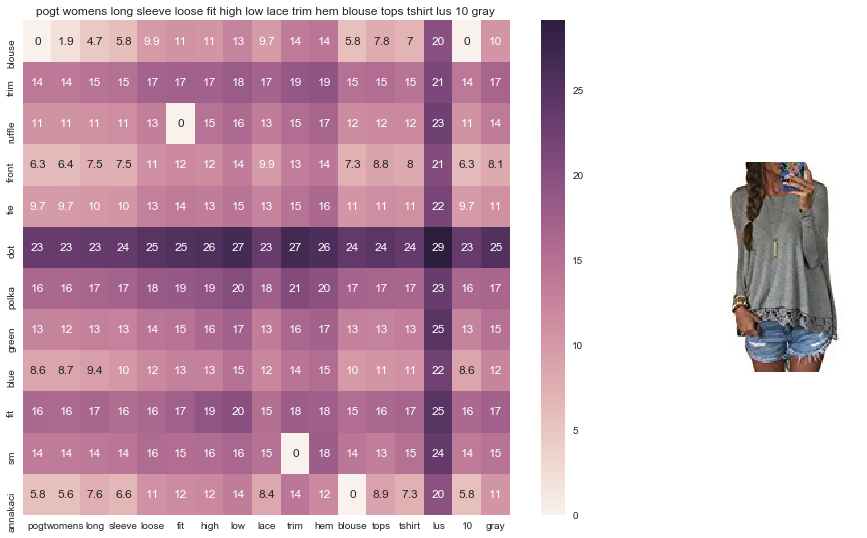

ASIN : B01M19NC0Y
Brand : POGT
euclidean distance from input : 3.77751


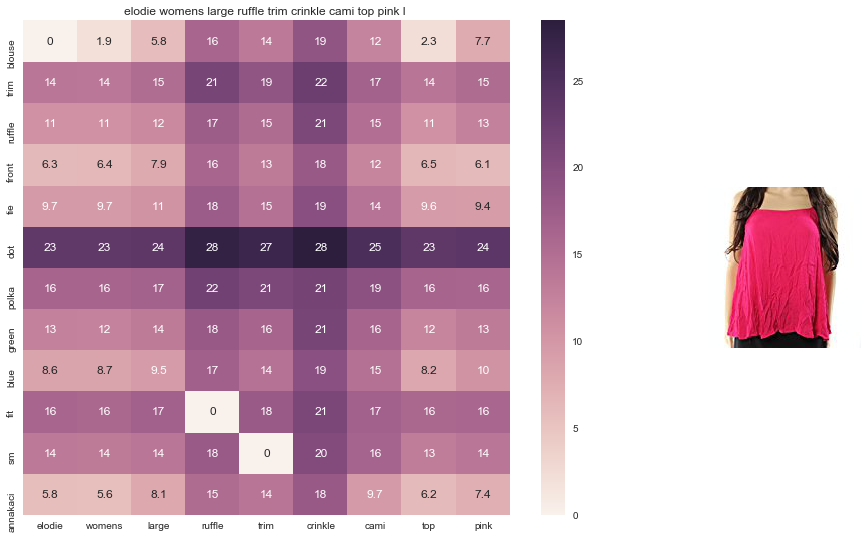

ASIN : B06XD3ZTCB
Brand : Elodie
euclidean distance from input : 3.77846


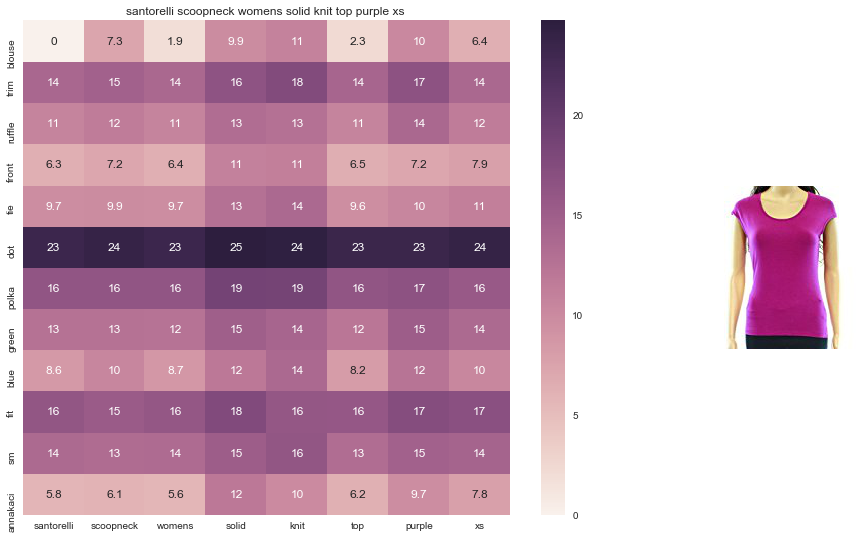

ASIN : B074QW18HZ
Brand : Santorelli
euclidean distance from input : 3.79467


In [28]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(931, 20)
#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j

### [9.6] Weighted similarity using brand and color.

In [29]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [30]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [31]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)
# in the give heat map, each cell contains the euclidean distance between words i, j

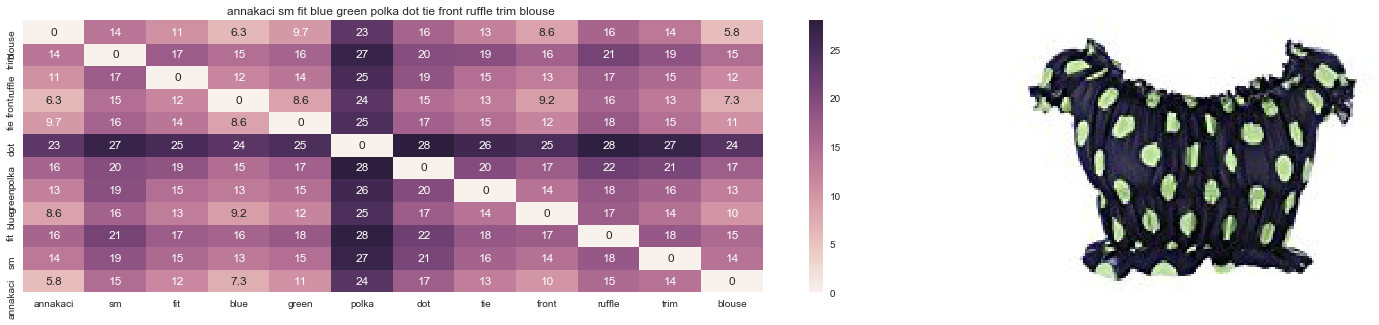

ASIN : B00KLHUIBS
Brand : Anna-Kaci
euclidean distance from input : 0.0


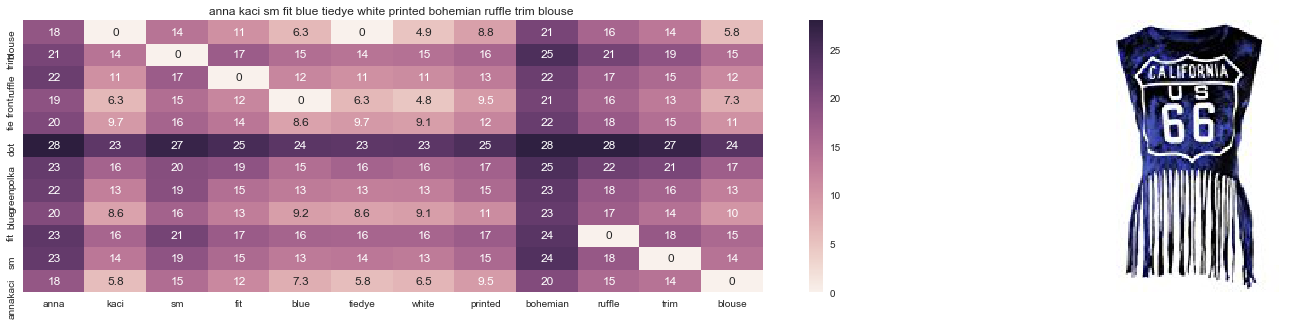

ASIN : B00YQ8S4K0
Brand : Anna-Kaci
euclidean distance from input : 1.90725736618


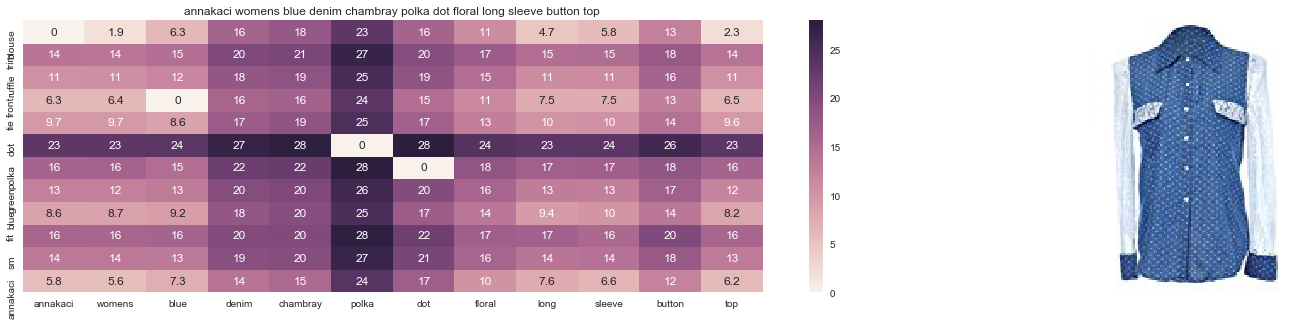

ASIN : B008SMIFN6
Brand : Anna-Kaci
euclidean distance from input : 2.00584926605


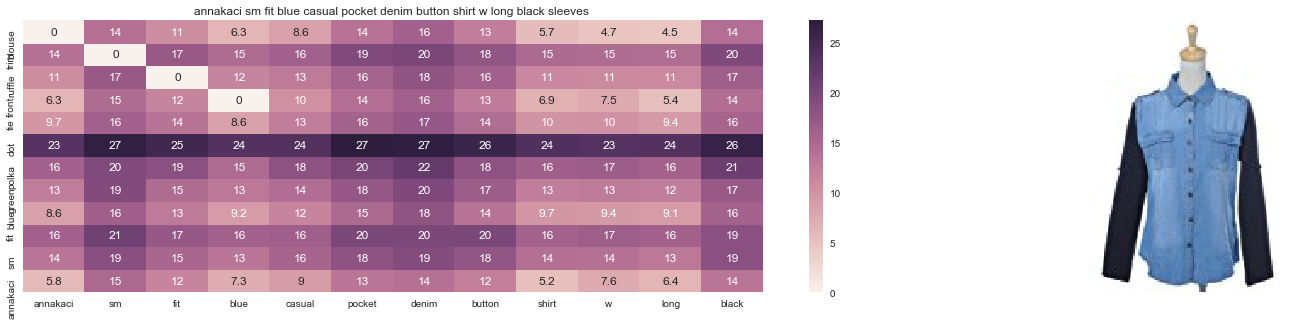

ASIN : B0097LQOOY
Brand : Anna-Kaci
euclidean distance from input : 2.14262800217


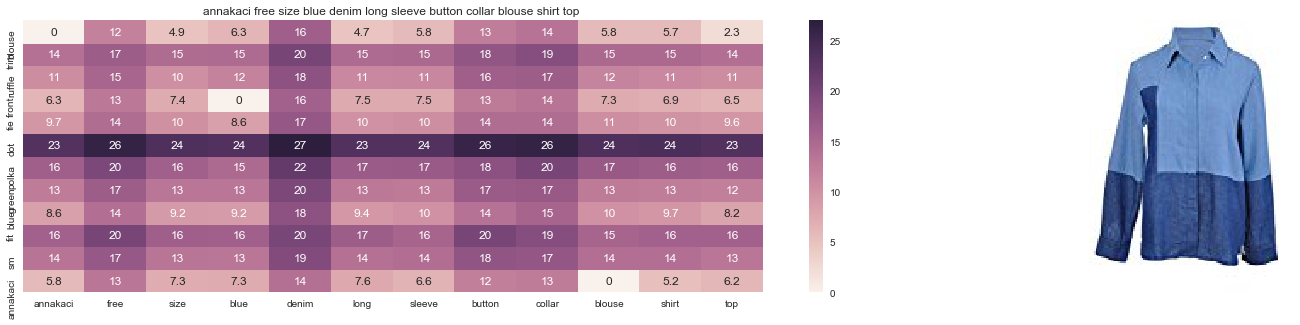

ASIN : B00726I25U
Brand : Anna-Kaci
euclidean distance from input : 2.2586856842


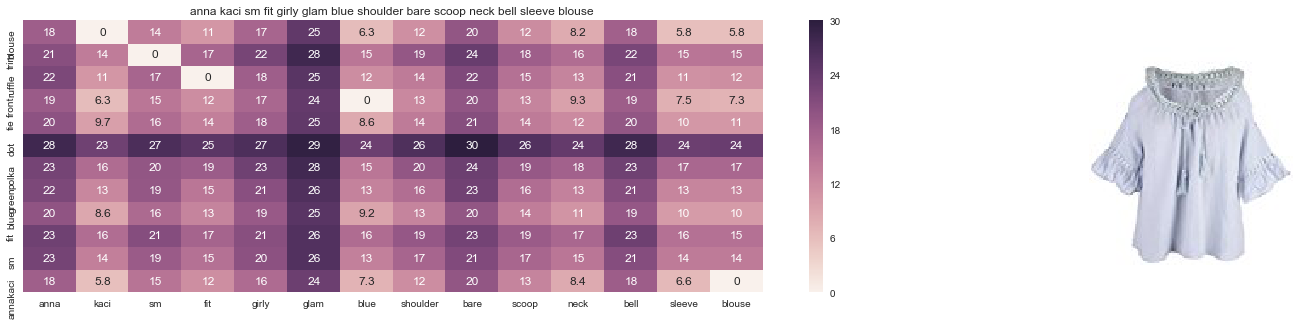

ASIN : B0128Z19IQ
Brand : Anna-Kaci
euclidean distance from input : 2.40793895721


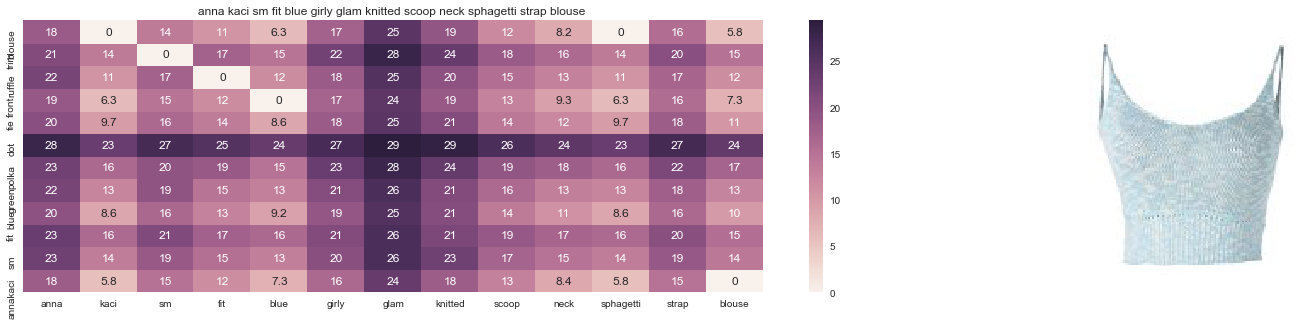

ASIN : B010EH1PCK
Brand : Anna-Kaci
euclidean distance from input : 2.44607467651


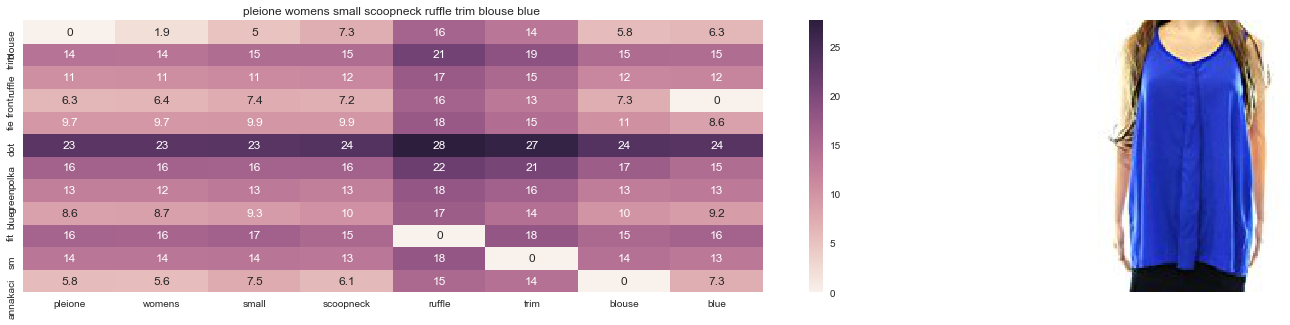

ASIN : B072VHTT1D
Brand : Pleione
euclidean distance from input : 2.48923406601


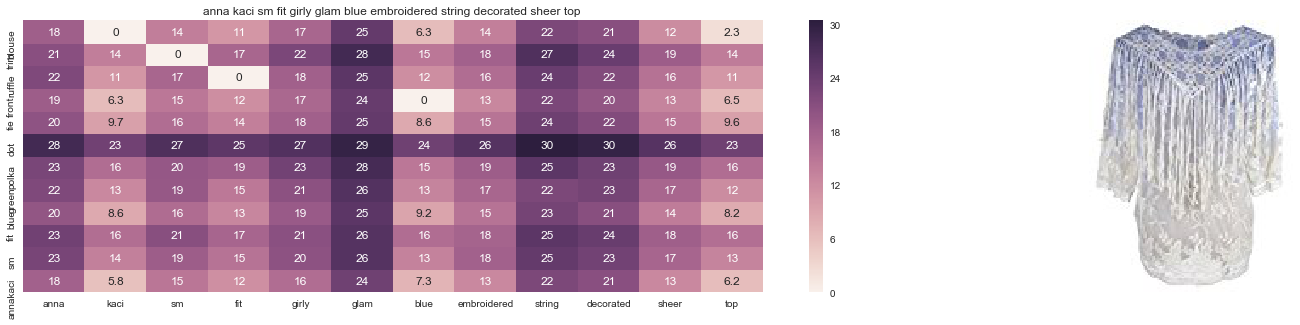

ASIN : B0128Z1BNO
Brand : Anna-Kaci
euclidean distance from input : 2.50260028839


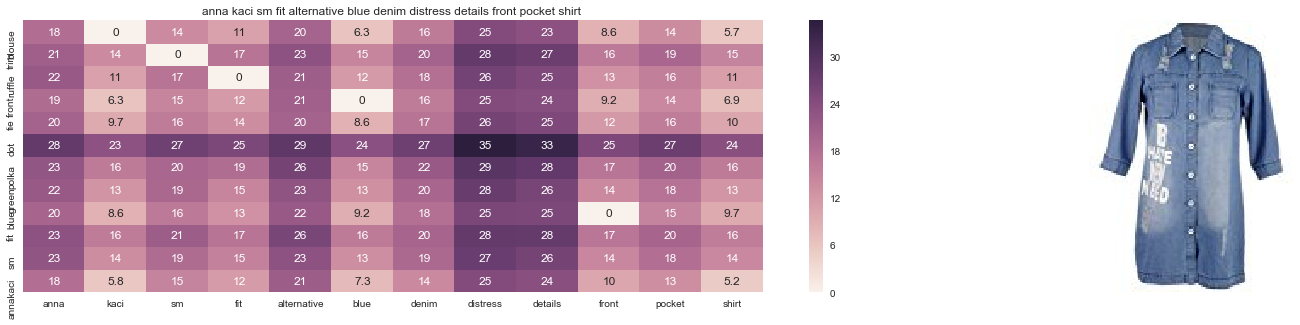

ASIN : B010EH2WCW
Brand : Anna-Kaci
euclidean distance from input : 2.5075088501


In [32]:
# brand and color weight =50
# title vector weight = 5

idf_w2v_brand(931, 15, 25, 10)

# [10.2] Keras and Tensorflow to extract features

In [33]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


In [34]:
# https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
# Code reference: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html



# This code takes 40 minutes to run on a modern GPU (graphics card) 
# like Nvidia  1050.
# GPU (NVidia 1050): 0.175 seconds per image

# This codse takes 160 minutes to run on a high end i7 CPU
# CPU (i7): 0.615 seconds per image.

#Do NOT run this code unless you want to wait a few hours for it to generate output

# each image is converted into 25088 length dense-vector


'''
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

'''

"\n# dimensions of our images.\nimg_width, img_height = 224, 224\n\ntop_model_weights_path = 'bottleneck_fc_model.h5'\ntrain_data_dir = 'images2/'\nnb_train_samples = 16042\nepochs = 50\nbatch_size = 1\n\n\ndef save_bottlebeck_features():\n    \n    #Function to compute VGG-16 CNN for image feature extraction.\n    \n    asins = []\n    datagen = ImageDataGenerator(rescale=1. / 255)\n    \n    # build the VGG16 network\n    model = applications.VGG16(include_top=False, weights='imagenet')\n    generator = datagen.flow_from_directory(\n        train_data_dir,\n        target_size=(img_width, img_height),\n        batch_size=batch_size,\n        class_mode=None,\n        shuffle=False)\n\n    for i in generator.filenames:\n        asins.append(i[2:-5])\n\n    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)\n    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))\n    \n    np.save(open('16k_data_cnn_features.npy', 'w

# [10.3] Visual features based product similarity.

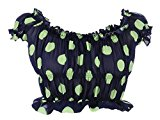

Product Title:  annakaci sm fit blue green polka dot tie front ruffle trim blouse 
Euclidean Distance from input image: 0.0698771
Amazon Url: www.amzon.com/dp/B00KLHUIBS


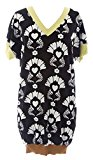

Product Title:  eternal child womens black floral printed vneck short sleeve tunic sz new 
Euclidean Distance from input image: 47.3915
Amazon Url: www.amzon.com/dp/B0184RPZNM


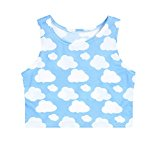

Product Title:  harajuku cloud printed elastic crop tops women 
Euclidean Distance from input image: 48.2155
Amazon Url: www.amzon.com/dp/B01KQHFVP0


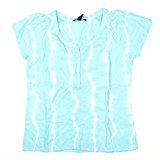

Product Title:  bandolino womens erin round v neck tie dyed shirt top small aqua refelction 
Euclidean Distance from input image: 48.5096
Amazon Url: www.amzon.com/dp/B00ROB8A8W


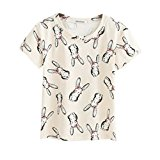

Product Title:  new kawaii cotton pastel tops tees rabbit design 
Euclidean Distance from input image: 48.6021
Amazon Url: www.amzon.com/dp/B074S5F9ZK


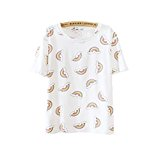

Product Title:  cute womens tops tees pastel rainbow print size 
Euclidean Distance from input image: 48.6988
Amazon Url: www.amzon.com/dp/B01415UNVU


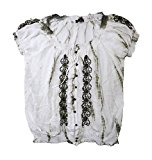

Product Title:  fever ladies size small rayon blouse white  green 
Euclidean Distance from input image: 48.7284
Amazon Url: www.amzon.com/dp/B0731PMQZ2


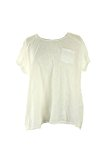

Product Title:  style  co plus size new whit cuffed shortsleeve tee 2x 1498 dbfl 
Euclidean Distance from input image: 48.8643
Amazon Url: www.amzon.com/dp/B0178WOJVS


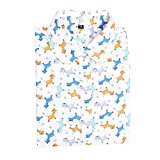

Product Title:  women blouses turn collar floral tops lady long sleeve shirt sxxxxl 
Euclidean Distance from input image: 48.9732
Amazon Url: www.amzon.com/dp/B07552VG9B


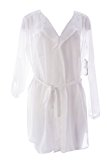

Product Title:  miraclebody miraclesuit womens roll sleeve long tunic sz medium ivory 
Euclidean Distance from input image: 49.0091
Amazon Url: www.amzon.com/dp/B01MUF826N


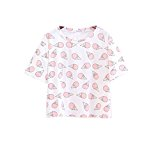

Product Title:  womens kawaii cotton pastel tops tees pink ice cream design 
Euclidean Distance from input image: 49.0551
Amazon Url: www.amzon.com/dp/B06XG3LBFC


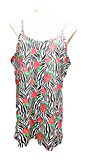

Product Title:  op juniors plus scoop neck tank 2x 1921 zebrarose 
Euclidean Distance from input image: 49.129
Amazon Url: www.amzon.com/dp/B06Y6KNDBG


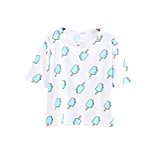

Product Title:  womens kawaii cotton pastel tops tees ice cream pop design 
Euclidean Distance from input image: 49.1513
Amazon Url: www.amzon.com/dp/B06XG1Q7SD


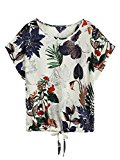

Product Title:  floerns womens tropical print drawstring hem tshirt onesize multicolor 
Euclidean Distance from input image: 49.156
Amazon Url: www.amzon.com/dp/B06VW9CZ8Y


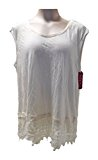

Product Title:  merona womens blouse shell xxl 
Euclidean Distance from input image: 49.2043
Amazon Url: www.amzon.com/dp/B06ZYH5VXR


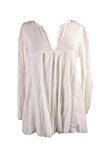

Product Title:  denim supply white lacetrim cotton swing tunic 
Euclidean Distance from input image: 49.213
Amazon Url: www.amzon.com/dp/B06XFNJXS7


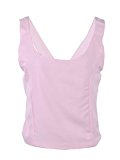

Product Title:  annakaci sm fit pink bow ribbon back trim racer detail shell style top 
Euclidean Distance from input image: 49.2163
Amazon Url: www.amzon.com/dp/B00KOBQEBO


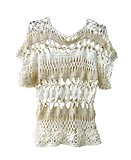

Product Title:  tinacrochetstudio crochet summer tops designer blouse short sleeve jumpsuits 
Euclidean Distance from input image: 49.2229
Amazon Url: www.amzon.com/dp/B016YGD3TI


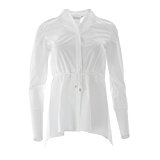

Product Title:  max mara womens curve tie waist button shirt sz 2 white 
Euclidean Distance from input image: 49.2399
Amazon Url: www.amzon.com/dp/B06WWJQ3P2


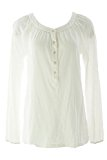

Product Title:  velvet graham  spencer womens buttondown cotton top small winter white 
Euclidean Distance from input image: 49.2802
Amazon Url: www.amzon.com/dp/B01MQJ2NV8


In [35]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(931, 20)


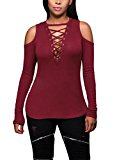

Product Title:  farysays womens casual cutout shoulder blouse laceup ribbed tops tshirt burgundy l 
Euclidean Distance from input image: 0.0192148581795
Amazon Url: www.amzon.com/dp/B01MF6DSHE


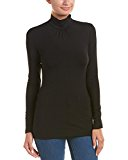

Product Title:  susana monaco womens susana monoco shirred top xs black 
Euclidean Distance from input image: 20.1371366629
Amazon Url: www.amzon.com/dp/B0753N2FWQ


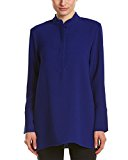

Product Title:  josie natori womens top blue 
Euclidean Distance from input image: 20.3629256086
Amazon Url: www.amzon.com/dp/B01NBXRIH8


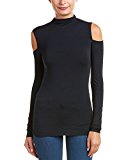

Product Title:  bailey44 womens bailey 44 mock neck coldshoulder top blue 
Euclidean Distance from input image: 20.4195596447
Amazon Url: www.amzon.com/dp/B074S8NRN3


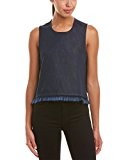

Product Title:  alc womens nina top 4 blue 
Euclidean Distance from input image: 20.4344670836
Amazon Url: www.amzon.com/dp/B01MPX3OQJ


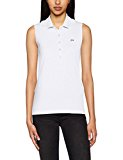

Product Title:  lacoste womens womens white pique polo size 46xxxl white 
Euclidean Distance from input image: 20.4405148261
Amazon Url: www.amzon.com/dp/B01M2AAJNP


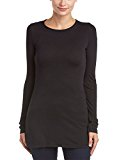

Product Title:  bobi womens bobi sharkbite tunic top xs black 
Euclidean Distance from input image: 20.4517362376
Amazon Url: www.amzon.com/dp/B01M4NNXXZ


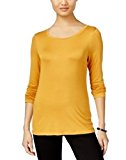

Product Title:  cable  gauge longsleeve knit top medium gold 
Euclidean Distance from input image: 20.4711040177
Amazon Url: www.amzon.com/dp/B0744NVRLT


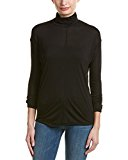

Product Title:  rag  bone womens jean turtleneck tshirt black 
Euclidean Distance from input image: 20.4759876628
Amazon Url: www.amzon.com/dp/B06XFL819P


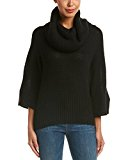

Product Title:  beulah womens beulah cowl woolblend sweater black 
Euclidean Distance from input image: 20.4899020289
Amazon Url: www.amzon.com/dp/B074RNVN73


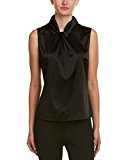

Product Title:  st john womens silkblend top p 
Euclidean Distance from input image: 20.65513717
Amazon Url: www.amzon.com/dp/B0753QB584


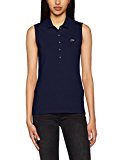

Product Title:  lacoste womens womens navy sleeveles pique polo size 463xl navy 
Euclidean Distance from input image: 20.7372932313
Amazon Url: www.amzon.com/dp/B01M3VNRG1


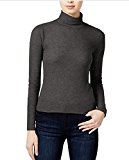

Product Title:  chelsea sky ribbed turtleneck 
Euclidean Distance from input image: 20.8069816559
Amazon Url: www.amzon.com/dp/B071ZBHPS4


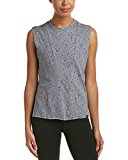

Product Title:  koral womens activewear move crop top xs 
Euclidean Distance from input image: 20.8108571802
Amazon Url: www.amzon.com/dp/B071XD14DR


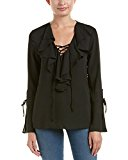

Product Title:  eci womens beige blouse 
Euclidean Distance from input image: 20.8424624901
Amazon Url: www.amzon.com/dp/B073VL1SQT


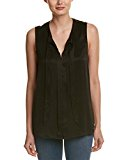

Product Title:  splendid womens tieneck blouse l black 
Euclidean Distance from input image: 20.8830022399
Amazon Url: www.amzon.com/dp/B0716F4X2L


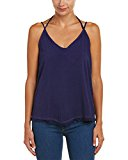

Product Title:  splendid womens double strap cami xl blue 
Euclidean Distance from input image: 20.905964151
Amazon Url: www.amzon.com/dp/B0746STR6M


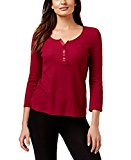

Product Title:  nautica long sleeve thermal henley pajama top beet red 
Euclidean Distance from input image: 20.9073130279
Amazon Url: www.amzon.com/dp/B01HH664BS


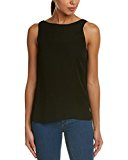

Product Title:  alice  olivia womens eldridge tank black 
Euclidean Distance from input image: 20.9502148382
Amazon Url: www.amzon.com/dp/B071G2YTJ4


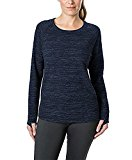

Product Title:  kirkland signature ladies crew pullover navy heather xlarge 
Euclidean Distance from input image: 20.9640575245
Amazon Url: www.amzon.com/dp/B074NGBTQ1


In [38]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])
#w1 for idf_w2v w2 for brand ,w3 for color and w4 for visual
def get_similar_products_all(doc_id, w1, w2, w3, w4, num_results):
    
    doc_id = asins.index(df_asins[doc_id])
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist=pairwise_distances(brand_features,brand_features[doc_id])
    color_dist=pairwise_distances(color_features,color_features[doc_id])
    cvv_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * brand_dist + w3 * color_dist + w4 * cvv_dist)/float(w1 + w2 + w3 + w4)


    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_all(143, 30 , 20, 15, 50, 20)

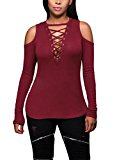

Product Title:  farysays womens casual cutout shoulder blouse laceup ribbed tops tshirt burgundy l 
Euclidean Distance from input image: 0.0166770467218
Amazon Url: www.amzon.com/dp/B01MF6DSHE


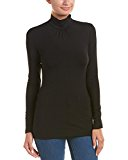

Product Title:  susana monaco womens susana monoco shirred top xs black 
Euclidean Distance from input image: 19.3084948482
Amazon Url: www.amzon.com/dp/B0753N2FWQ


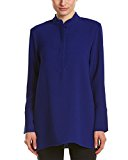

Product Title:  josie natori womens top blue 
Euclidean Distance from input image: 19.5712131929
Amazon Url: www.amzon.com/dp/B01NBXRIH8


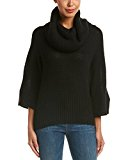

Product Title:  beulah womens beulah cowl woolblend sweater black 
Euclidean Distance from input image: 19.6016752318
Amazon Url: www.amzon.com/dp/B074RNVN73


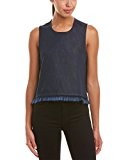

Product Title:  alc womens nina top 4 blue 
Euclidean Distance from input image: 19.6346910585
Amazon Url: www.amzon.com/dp/B01MPX3OQJ


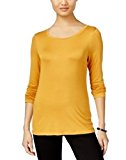

Product Title:  cable  gauge longsleeve knit top medium gold 
Euclidean Distance from input image: 19.6403225988
Amazon Url: www.amzon.com/dp/B0744NVRLT


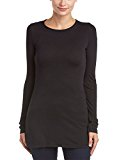

Product Title:  bobi womens bobi sharkbite tunic top xs black 
Euclidean Distance from input image: 19.6507233586
Amazon Url: www.amzon.com/dp/B01M4NNXXZ


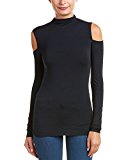

Product Title:  bailey44 womens bailey 44 mock neck coldshoulder top blue 
Euclidean Distance from input image: 19.9155932733
Amazon Url: www.amzon.com/dp/B074S8NRN3


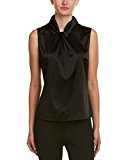

Product Title:  st john womens silkblend top p 
Euclidean Distance from input image: 19.9693548815
Amazon Url: www.amzon.com/dp/B0753QB584


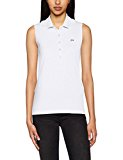

Product Title:  lacoste womens womens white pique polo size 46xxxl white 
Euclidean Distance from input image: 19.971165286
Amazon Url: www.amzon.com/dp/B01M2AAJNP


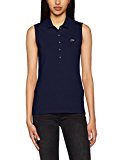

Product Title:  lacoste womens womens navy sleeveles pique polo size 463xl navy 
Euclidean Distance from input image: 20.021594605
Amazon Url: www.amzon.com/dp/B01M3VNRG1


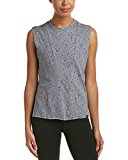

Product Title:  koral womens activewear move crop top xs 
Euclidean Distance from input image: 20.0597560879
Amazon Url: www.amzon.com/dp/B071XD14DR


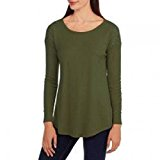

Product Title:  french laundry womens ribbed tunic lace trim olive camo xl 
Euclidean Distance from input image: 20.0689148737
Amazon Url: www.amzon.com/dp/B06XNJHPDS


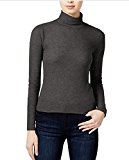

Product Title:  chelsea sky ribbed turtleneck 
Euclidean Distance from input image: 20.0700765253
Amazon Url: www.amzon.com/dp/B071ZBHPS4


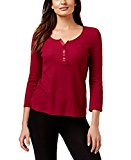

Product Title:  nautica long sleeve thermal henley pajama top beet red 
Euclidean Distance from input image: 20.0781168448
Amazon Url: www.amzon.com/dp/B01HH664BS


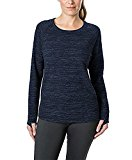

Product Title:  kirkland signature ladies crew pullover navy heather xlarge 
Euclidean Distance from input image: 20.0877420678
Amazon Url: www.amzon.com/dp/B074NGBTQ1


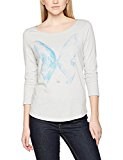

Product Title:  esprit womens womens cotton white top print size offwhite 
Euclidean Distance from input image: 20.1356530532
Amazon Url: www.amzon.com/dp/B01MXNZ7XX


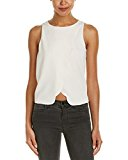

Product Title:  esley womens scalloped blouse l 
Euclidean Distance from input image: 20.1508377707
Amazon Url: www.amzon.com/dp/B01M716OVC


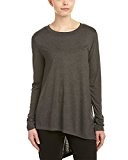

Product Title:  kristy  chloe womens asymmetrical hem tunic xs grey 
Euclidean Distance from input image: 20.156508557
Amazon Url: www.amzon.com/dp/B01M2926D0


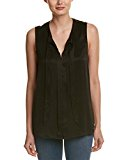

Product Title:  splendid womens tieneck blouse l black 
Euclidean Distance from input image: 20.1745850186
Amazon Url: www.amzon.com/dp/B0716F4X2L


In [37]:
#giving weightage to idf and cvv
get_similar_products_all(143, 140 , 15, 10, 100, 20)

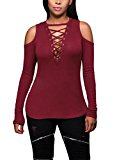

Product Title:  farysays womens casual cutout shoulder blouse laceup ribbed tops tshirt burgundy l 
Euclidean Distance from input image: 0.0107790667836
Amazon Url: www.amzon.com/dp/B01MF6DSHE


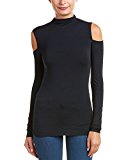

Product Title:  bailey44 womens bailey 44 mock neck coldshoulder top blue 
Euclidean Distance from input image: 11.7833548942
Amazon Url: www.amzon.com/dp/B074S8NRN3


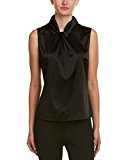

Product Title:  st john womens silkblend top p 
Euclidean Distance from input image: 11.8911568247
Amazon Url: www.amzon.com/dp/B0753QB584


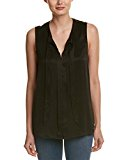

Product Title:  splendid womens tieneck blouse l black 
Euclidean Distance from input image: 12.0201890155
Amazon Url: www.amzon.com/dp/B0716F4X2L


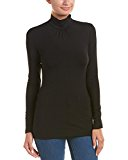

Product Title:  susana monaco womens susana monoco shirred top xs black 
Euclidean Distance from input image: 12.1717308507
Amazon Url: www.amzon.com/dp/B0753N2FWQ


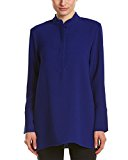

Product Title:  josie natori womens top blue 
Euclidean Distance from input image: 12.3091788964
Amazon Url: www.amzon.com/dp/B01NBXRIH8


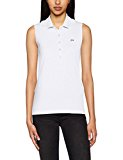

Product Title:  lacoste womens womens white pique polo size 46xxxl white 
Euclidean Distance from input image: 12.4064495828
Amazon Url: www.amzon.com/dp/B01M2AAJNP


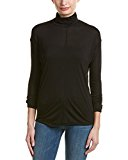

Product Title:  rag  bone womens jean turtleneck tshirt black 
Euclidean Distance from input image: 12.4572373829
Amazon Url: www.amzon.com/dp/B06XFL819P


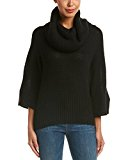

Product Title:  beulah womens beulah cowl woolblend sweater black 
Euclidean Distance from input image: 12.5015155456
Amazon Url: www.amzon.com/dp/B074RNVN73


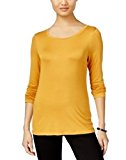

Product Title:  cable  gauge longsleeve knit top medium gold 
Euclidean Distance from input image: 12.501522272
Amazon Url: www.amzon.com/dp/B0744NVRLT


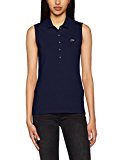

Product Title:  lacoste womens womens navy sleeveles pique polo size 463xl navy 
Euclidean Distance from input image: 12.5394623079
Amazon Url: www.amzon.com/dp/B01M3VNRG1


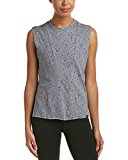

Product Title:  koral womens activewear move crop top xs 
Euclidean Distance from input image: 12.5765792751
Amazon Url: www.amzon.com/dp/B071XD14DR


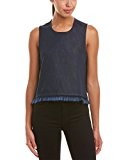

Product Title:  alc womens nina top 4 blue 
Euclidean Distance from input image: 12.5978957014
Amazon Url: www.amzon.com/dp/B01MPX3OQJ


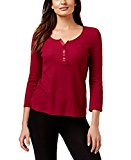

Product Title:  nautica long sleeve thermal henley pajama top beet red 
Euclidean Distance from input image: 12.6201281568
Amazon Url: www.amzon.com/dp/B01HH664BS


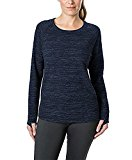

Product Title:  kirkland signature ladies crew pullover navy heather xlarge 
Euclidean Distance from input image: 12.6438868827
Amazon Url: www.amzon.com/dp/B074NGBTQ1


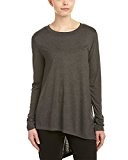

Product Title:  kristy  chloe womens asymmetrical hem tunic xs grey 
Euclidean Distance from input image: 12.67564901
Amazon Url: www.amzon.com/dp/B01M2926D0


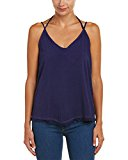

Product Title:  splendid womens double strap cami xl blue 
Euclidean Distance from input image: 12.7062830015
Amazon Url: www.amzon.com/dp/B0746STR6M


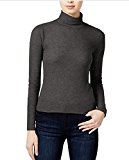

Product Title:  chelsea sky ribbed turtleneck 
Euclidean Distance from input image: 12.7106076997
Amazon Url: www.amzon.com/dp/B071ZBHPS4


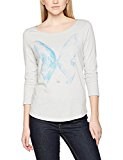

Product Title:  esprit womens womens cotton white top print size offwhite 
Euclidean Distance from input image: 12.7194817522
Amazon Url: www.amzon.com/dp/B01MXNZ7XX


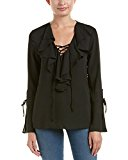

Product Title:  eci womens beige blouse 
Euclidean Distance from input image: 12.7328317784
Amazon Url: www.amzon.com/dp/B073VL1SQT


In [39]:
#giving weightage to color
get_similar_products_all(143, 40 , 15, 100, 50, 20)